## Notebook to visualize colocalization results as a heatmap

In [1]:
!date

Fri Feb  3 20:58:23 UTC 2023


#### import libraries

In [2]:
from pandas import read_csv, concat, pivot, read_pickle
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
from seaborn import heatmap
from os.path import exists
from math import ceil
import numpy as np

%matplotlib inline
# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

#### set notebook variables

In [3]:
# naming
cohort = 'foundin'
dx = 'PD'

# directories
wrk_dir = '/home/jupyter/foundin_qtl'
results_dir = f'{wrk_dir}/results'
figures_dir = f'{wrk_dir}/figures'
quants_dir = f'{wrk_dir}/quants'
public_dir = f'{wrk_dir}/public'

# out files
figure_file = f'{figures_dir}/{cohort}.colocalization.{dx}.png'
rnab_features_file = f'{public_dir}/gencode_v29.lncipedia_v5_2_hc.annotation.pkl'
pdui_features_file = f'{quants_dir}/{cohort}_PDUI.features.csv'

# variables
DEBUG = False
days = ['da0', 'da25', 'da65', 'daNA']
# modalities = ['ATAC', 'METH', 'PDUI', 'RNAB', 'RNAS', 'CIRC', 'SCRN-DA', 'SCRN-ElC', 
#               'SCRN-eNP', 'SCRN-iDA', 'SCRN-lNP', 'SCRN-NlC', 'SCRN-PFPP']
modalities = ['PDUI', 'RNAB', 'RNAS', 'CIRC', 'SCRN-DA', 'SCRN-ElC', 
              'SCRN-eNP', 'SCRN-iDA', 'SCRN-lNP', 'SCRN-NlC', 'SCRN-PFPP', 
              'PDUI-DA', 'PDUI-iDA',
              'Bryois-Astro', 'Bryois-Endo', 'Bryois-ExN', 'Bryois-InN', 
              'Bryois-Micro', 'Bryois-OPC', 'Bryois-Oligo', 'Bryois-Peri', 
              'Bulk-meta', 'DAn-meta']
dpi_value = 100
min_h4 = 0.2

### for each day and modality load the colocalization results

In [4]:
coloc_df = None
for day in days:
    for modality in modalities:
        print(day, modality, end=':')
        in_file = f'{results_dir}/{cohort}_{day}_{modality}_{dx}.coloc.pp.csv'
        if exists(in_file):
            this_df = read_csv(in_file)
            print(f'loaded {this_df.shape[0]} results')
            # add day and modality
            this_df['day'] = day
            this_df['modality'] = modality
            coloc_df = concat([coloc_df, this_df])
print(f'\ntotal results loaded {coloc_df.shape[0]}')
if DEBUG:
    display(coloc_df.sample(5))
    display(coloc_df.day.value_counts())
    display(coloc_df.modality.value_counts())        

da0 PDUI:loaded 59 results
da0 RNAB:loaded 53 results
da0 RNAS:loaded 1 results
da0 CIRC:da0 SCRN-DA:da0 SCRN-ElC:da0 SCRN-eNP:da0 SCRN-iDA:da0 SCRN-lNP:da0 SCRN-NlC:da0 SCRN-PFPP:da0 PDUI-DA:da0 PDUI-iDA:da0 Bryois-Astro:da0 Bryois-Endo:da0 Bryois-ExN:da0 Bryois-InN:da0 Bryois-Micro:da0 Bryois-OPC:da0 Bryois-Oligo:da0 Bryois-Peri:da0 Bulk-meta:da0 DAn-meta:da25 PDUI:loaded 55 results
da25 RNAB:loaded 48 results
da25 RNAS:loaded 3 results
da25 CIRC:loaded 2 results
da25 SCRN-DA:da25 SCRN-ElC:da25 SCRN-eNP:da25 SCRN-iDA:da25 SCRN-lNP:da25 SCRN-NlC:da25 SCRN-PFPP:da25 PDUI-DA:da25 PDUI-iDA:da25 Bryois-Astro:da25 Bryois-Endo:da25 Bryois-ExN:da25 Bryois-InN:da25 Bryois-Micro:da25 Bryois-OPC:da25 Bryois-Oligo:da25 Bryois-Peri:da25 Bulk-meta:da25 DAn-meta:da65 PDUI:loaded 31 results
da65 RNAB:loaded 45 results
da65 RNAS:da65 CIRC:loaded 1 results
da65 SCRN-DA:loaded 15 results
da65 SCRN-ElC:loaded 14 results
da65 SCRN-eNP:loaded 30 results
da65 SCRN-iDA:loaded 17 results
da65 SCRN-lNP:loaded

### load needed feature information

#### load RNAB features
RNAB features use Ensembl IDs need to map to gene names

In [5]:
%%time
annots_df = read_pickle(rnab_features_file)
print(f'annotations shape: {annots_df.shape}')

if DEBUG:
    display(annots_df.head())

annotations shape: (3072652, 50)
CPU times: user 6.53 s, sys: 3.47 s, total: 10 s
Wall time: 13.3 s


##### deference feature IDs to features names

In [6]:
feature_annots = annots_df.loc[annots_df.gene_id.isin(coloc_df.feature)]
feature_annots = feature_annots[['gene_id', 'gene_name']]
feature_annots = feature_annots.drop_duplicates()
features_dict = feature_annots.set_index('gene_id').to_dict()['gene_name']
if DEBUG:
    display(features_dict)

#### replace the RNAB features

In [7]:
coloc_df.feature.replace(features_dict, inplace=True)
print(f'update df shape {coloc_df.shape}')
if DEBUG:
    display(coloc_df.loc[coloc_df.modality == 'RNAB'].head())

update df shape (771, 9)


#### load PDUI features

In [8]:
%%time
annots_df = read_csv(pdui_features_file)
print(f'annotations shape: {annots_df.shape}')

if DEBUG:
    display(annots_df.head())

annotations shape: (58921, 7)
CPU times: user 916 ms, sys: 335 ms, total: 1.25 s
Wall time: 1.39 s


##### deference feature IDs to features names

In [9]:
feature_annots = annots_df.loc[annots_df.Loci.isin(coloc_df.feature)]
feature_annots = feature_annots[['Loci', 'Gene']]
# some genes have multiple PDUI features, append to handle
multi_features = feature_annots.duplicated(subset=['Gene'], keep=False)
feature_annots.loc[multi_features, 'Gene'] = feature_annots.Gene + ':' + feature_annots.Loci
# feature_annots.drop_duplicates(inplace=True)
features_dict = feature_annots.set_index('Loci').to_dict()['Gene']
if DEBUG:
    display(features_dict)

#### replace the PDUI features

In [10]:
coloc_df.feature.replace(features_dict, inplace=True)
print(f'update df shape {coloc_df.shape}')
if DEBUG:
    display(coloc_df.loc[coloc_df.modality == 'PDUI'].head())

update df shape (771, 9)


### subset based on the minimum H4 variable

In [11]:
temp = coloc_df.loc[coloc_df.H4 > min_h4]
print(f'{temp.feature.nunique()} traits will be used')
coloc_df = coloc_df.loc[coloc_df.feature.isin(temp.feature)]
print(f'results shape after filter on H4 {coloc_df.shape}')
if DEBUG:
    display(coloc_df.head())

286 traits will be used
results shape after filter on H4 (583, 9)


### reshape the dataframe from long to wide

In [12]:
# drop the cols we don't need
temp_df = coloc_df.drop(columns=['H0', 'H1', 'H2', 'H3', 'h4_supported'])
# sort not sure if this will help may have to set order in plotting explicityly
temp_df = temp_df.sort_values(by=['modality', 'day'])
# want day/modality combo's so combine
temp_df['day_modality'] = temp_df.day + '-' + temp_df.modality
# wcoloc_df = pivot(temp_df, index='feature', columns='day_modality', values='H4')
wcoloc_df = pivot(temp_df, index='feature', columns=['day', 'modality'], values='H4')
# set precision
wcoloc_df = wcoloc_df.round(2)
#replace all zeros with NaN values
wcoloc_df.replace(0, np.nan, inplace=True)
# drop rows that are all null
wcoloc_df.dropna(how='all', inplace=True)
# # sort by foundin DA neuron results
# wcoloc_df = wcoloc_df.sort_values(by=[('daNA', 'DAn-meta'), ('da65', 'SCRN-DA'), 
#                                       ('da65', 'SCRN-iDA'), 
#                                       ('daNA', 'Bulk-meta'), ('da65', 'RNAB'), 
#                                       ('da65', 'PDUI'),
#                                       ('daNA', 'Bryois-ExN'), ('daNA', 'Bryois-InN'), 
#                                       ('daNA', 'Bryois-Micro'), ('daNA', 'Bryois-Astro'), 
#                                       ('daNA', 'Bryois-Oligo')], ascending=False)
print(f'shape of wide reformated results {wcoloc_df.shape}')
if DEBUG:
    display(wcoloc_df)

shape of wide reformated results (286, 26)


### visualize the reformated data as a heatmap

PD 57


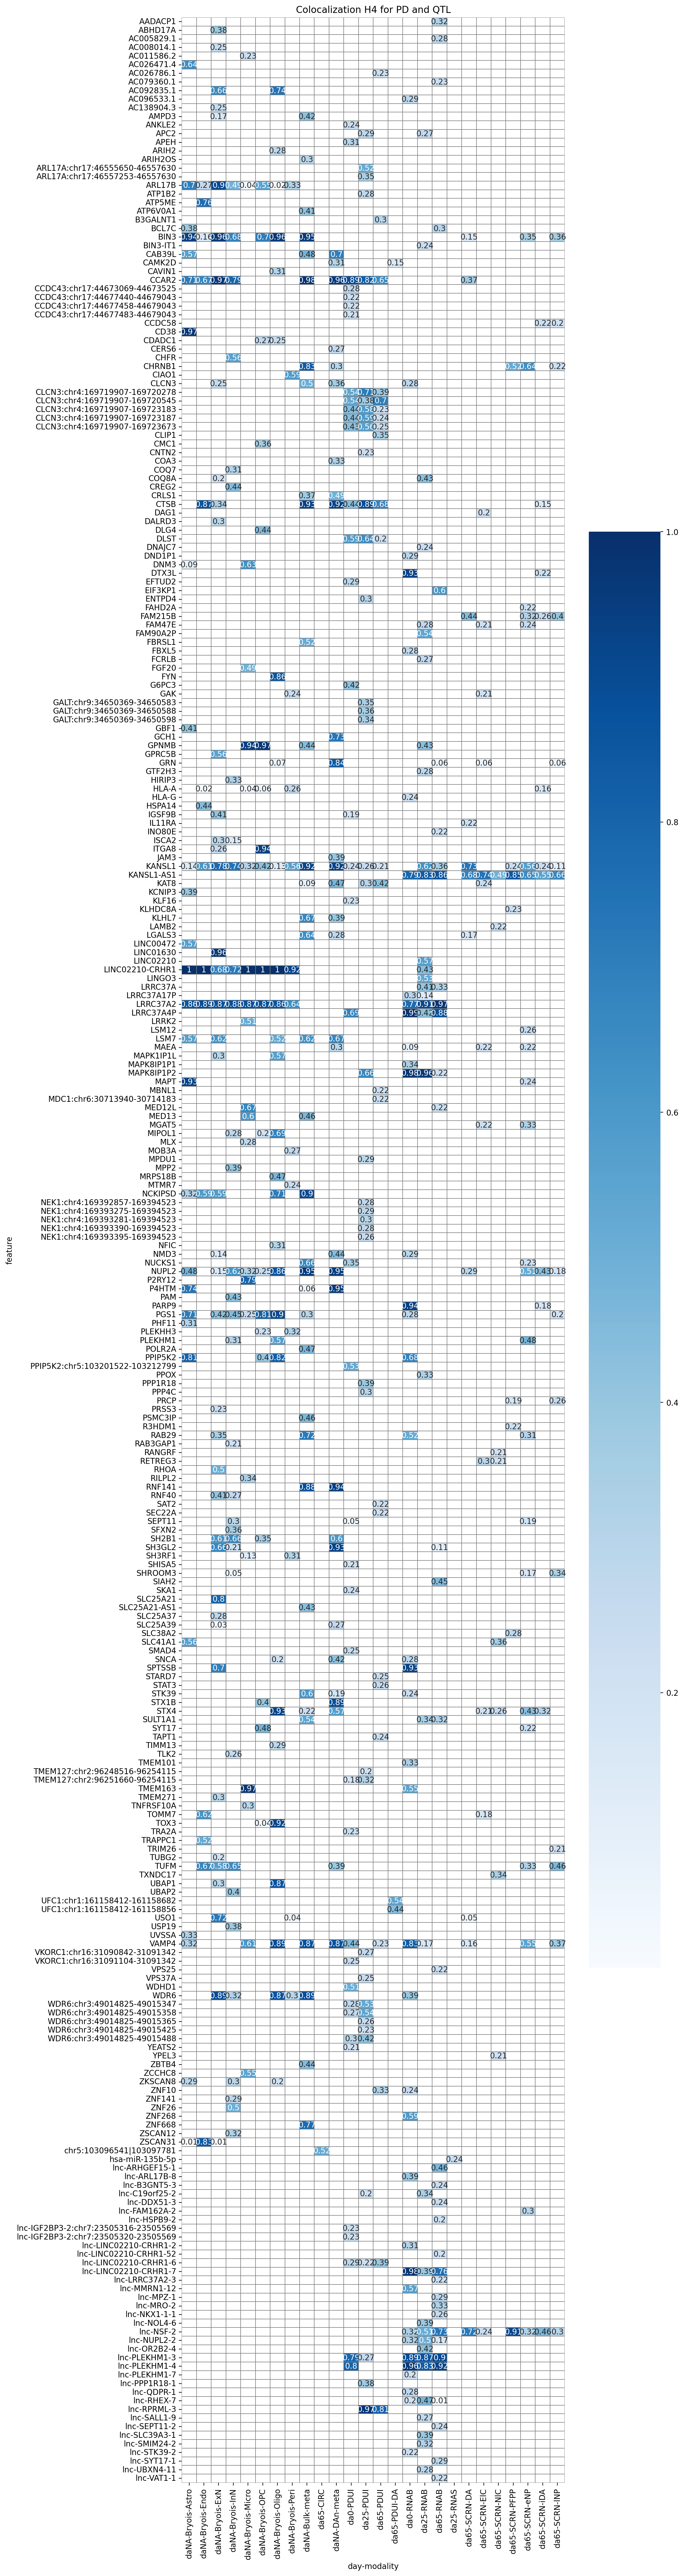

In [13]:

if wcoloc_df.shape[0] > 9:
    height = 9+ceil(wcoloc_df.shape[0]/6)
else:
    height = 9
print(dx, height)        
with rc_context({'figure.figsize': (11, height), 'figure.dpi': dpi_value}):
    plt.style.use('seaborn-bright')    
    heatmap(wcoloc_df, annot=True, linecolor='grey',
            annot_kws={"fontsize":10}, linewidths=0.05, cmap='Blues')    
    plt.title(f'Colocalization H4 for {dx} and QTL')
    plt.savefig(figure_file, dpi=dpi_value, bbox_inches='tight', 
                transparent=True, pad_inches=1)
    plt.show()

### visualize colocalization heatmap by modality and sorted

DAn-meta
(30, 26)


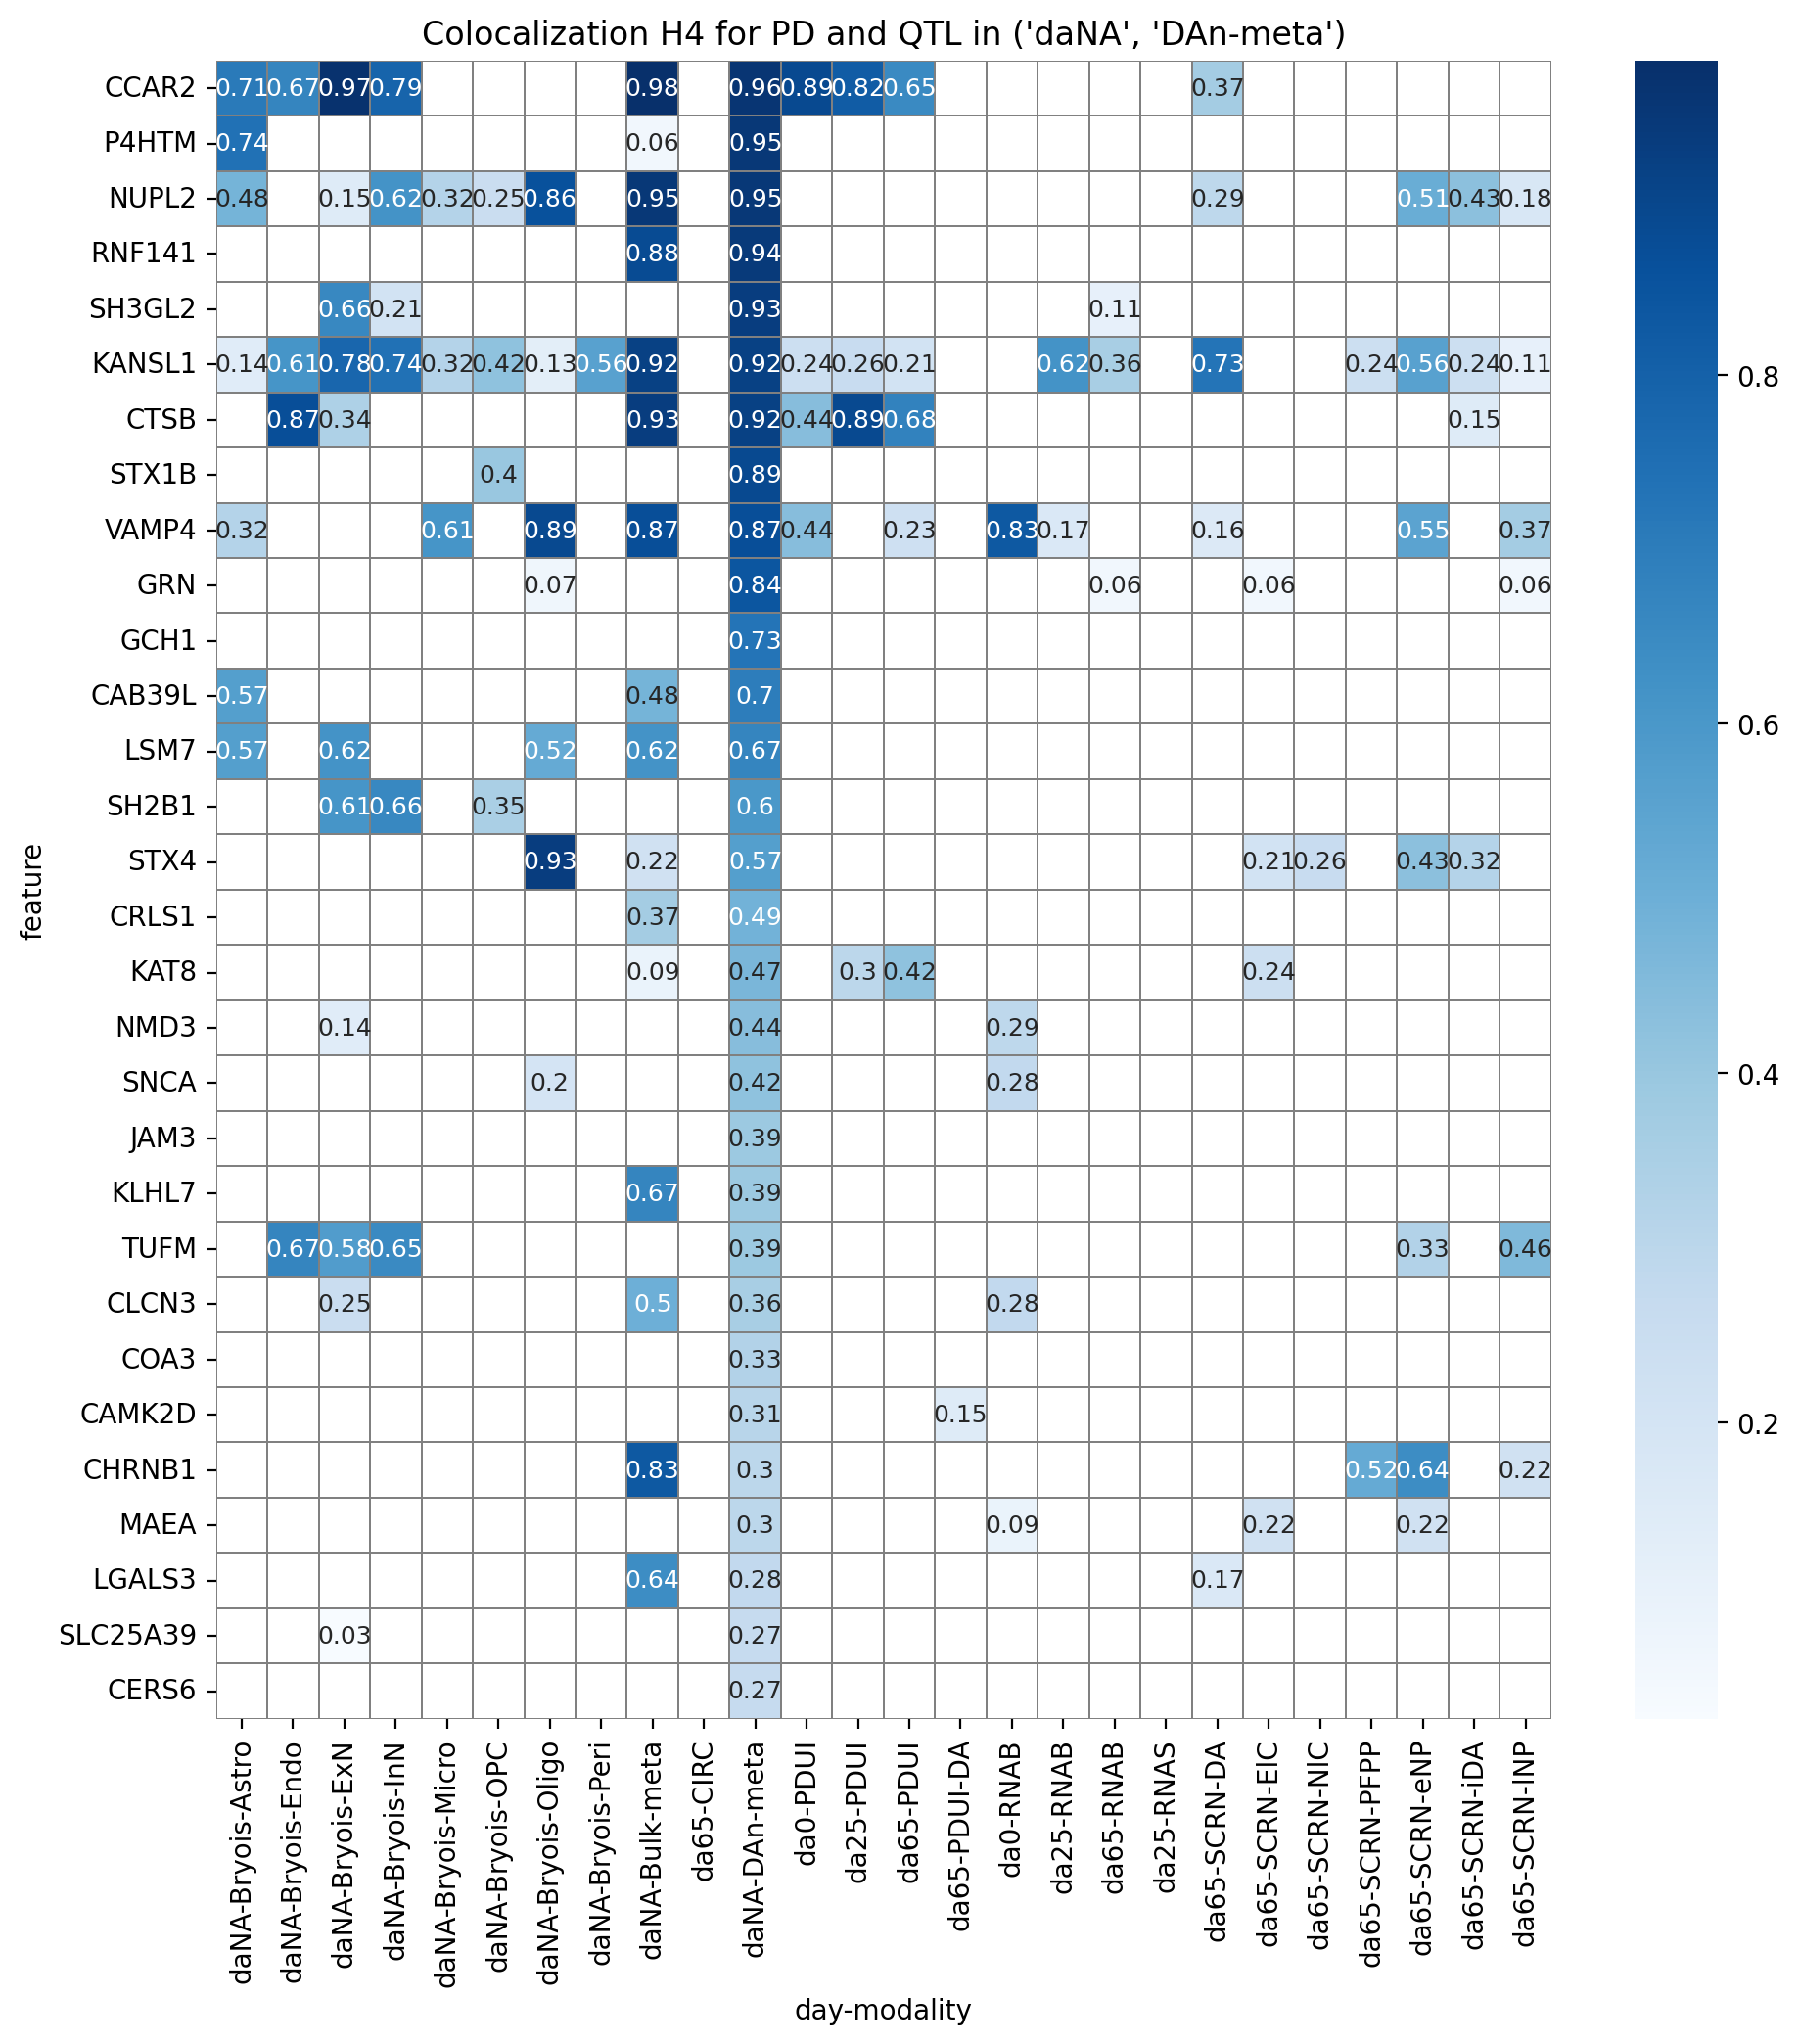

Bulk-meta
(33, 26)


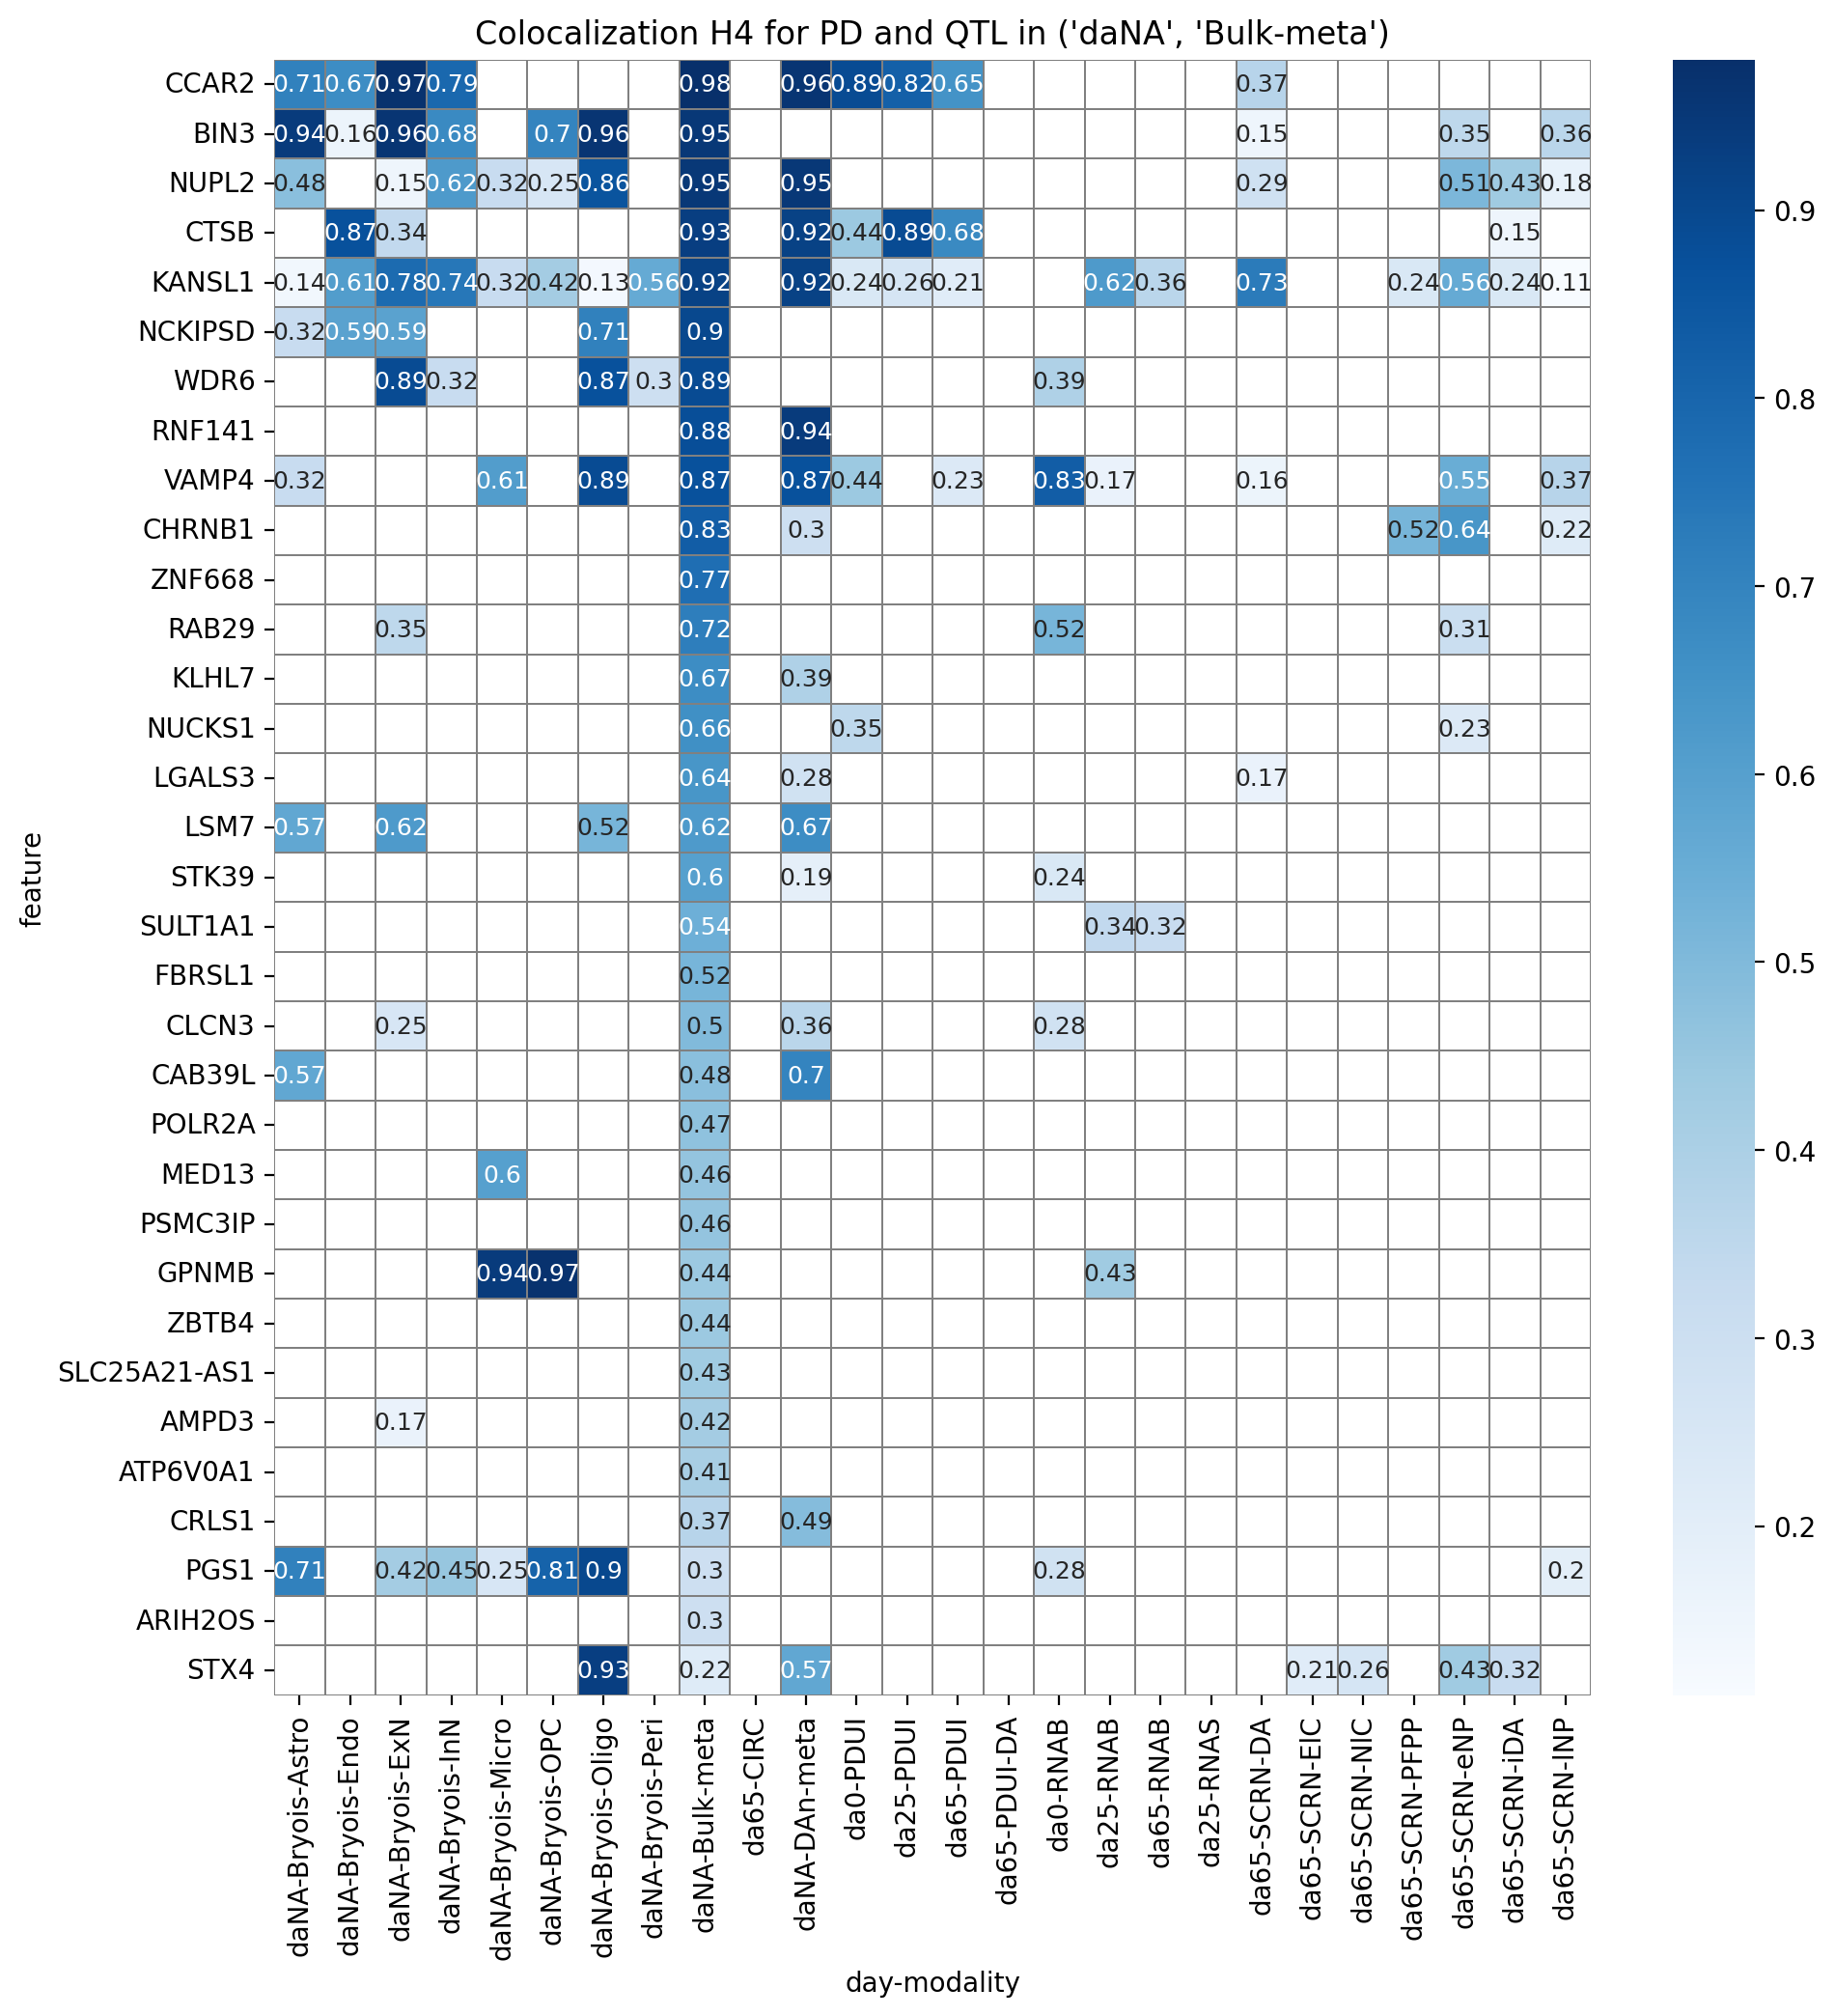

PDUI
(23, 26)


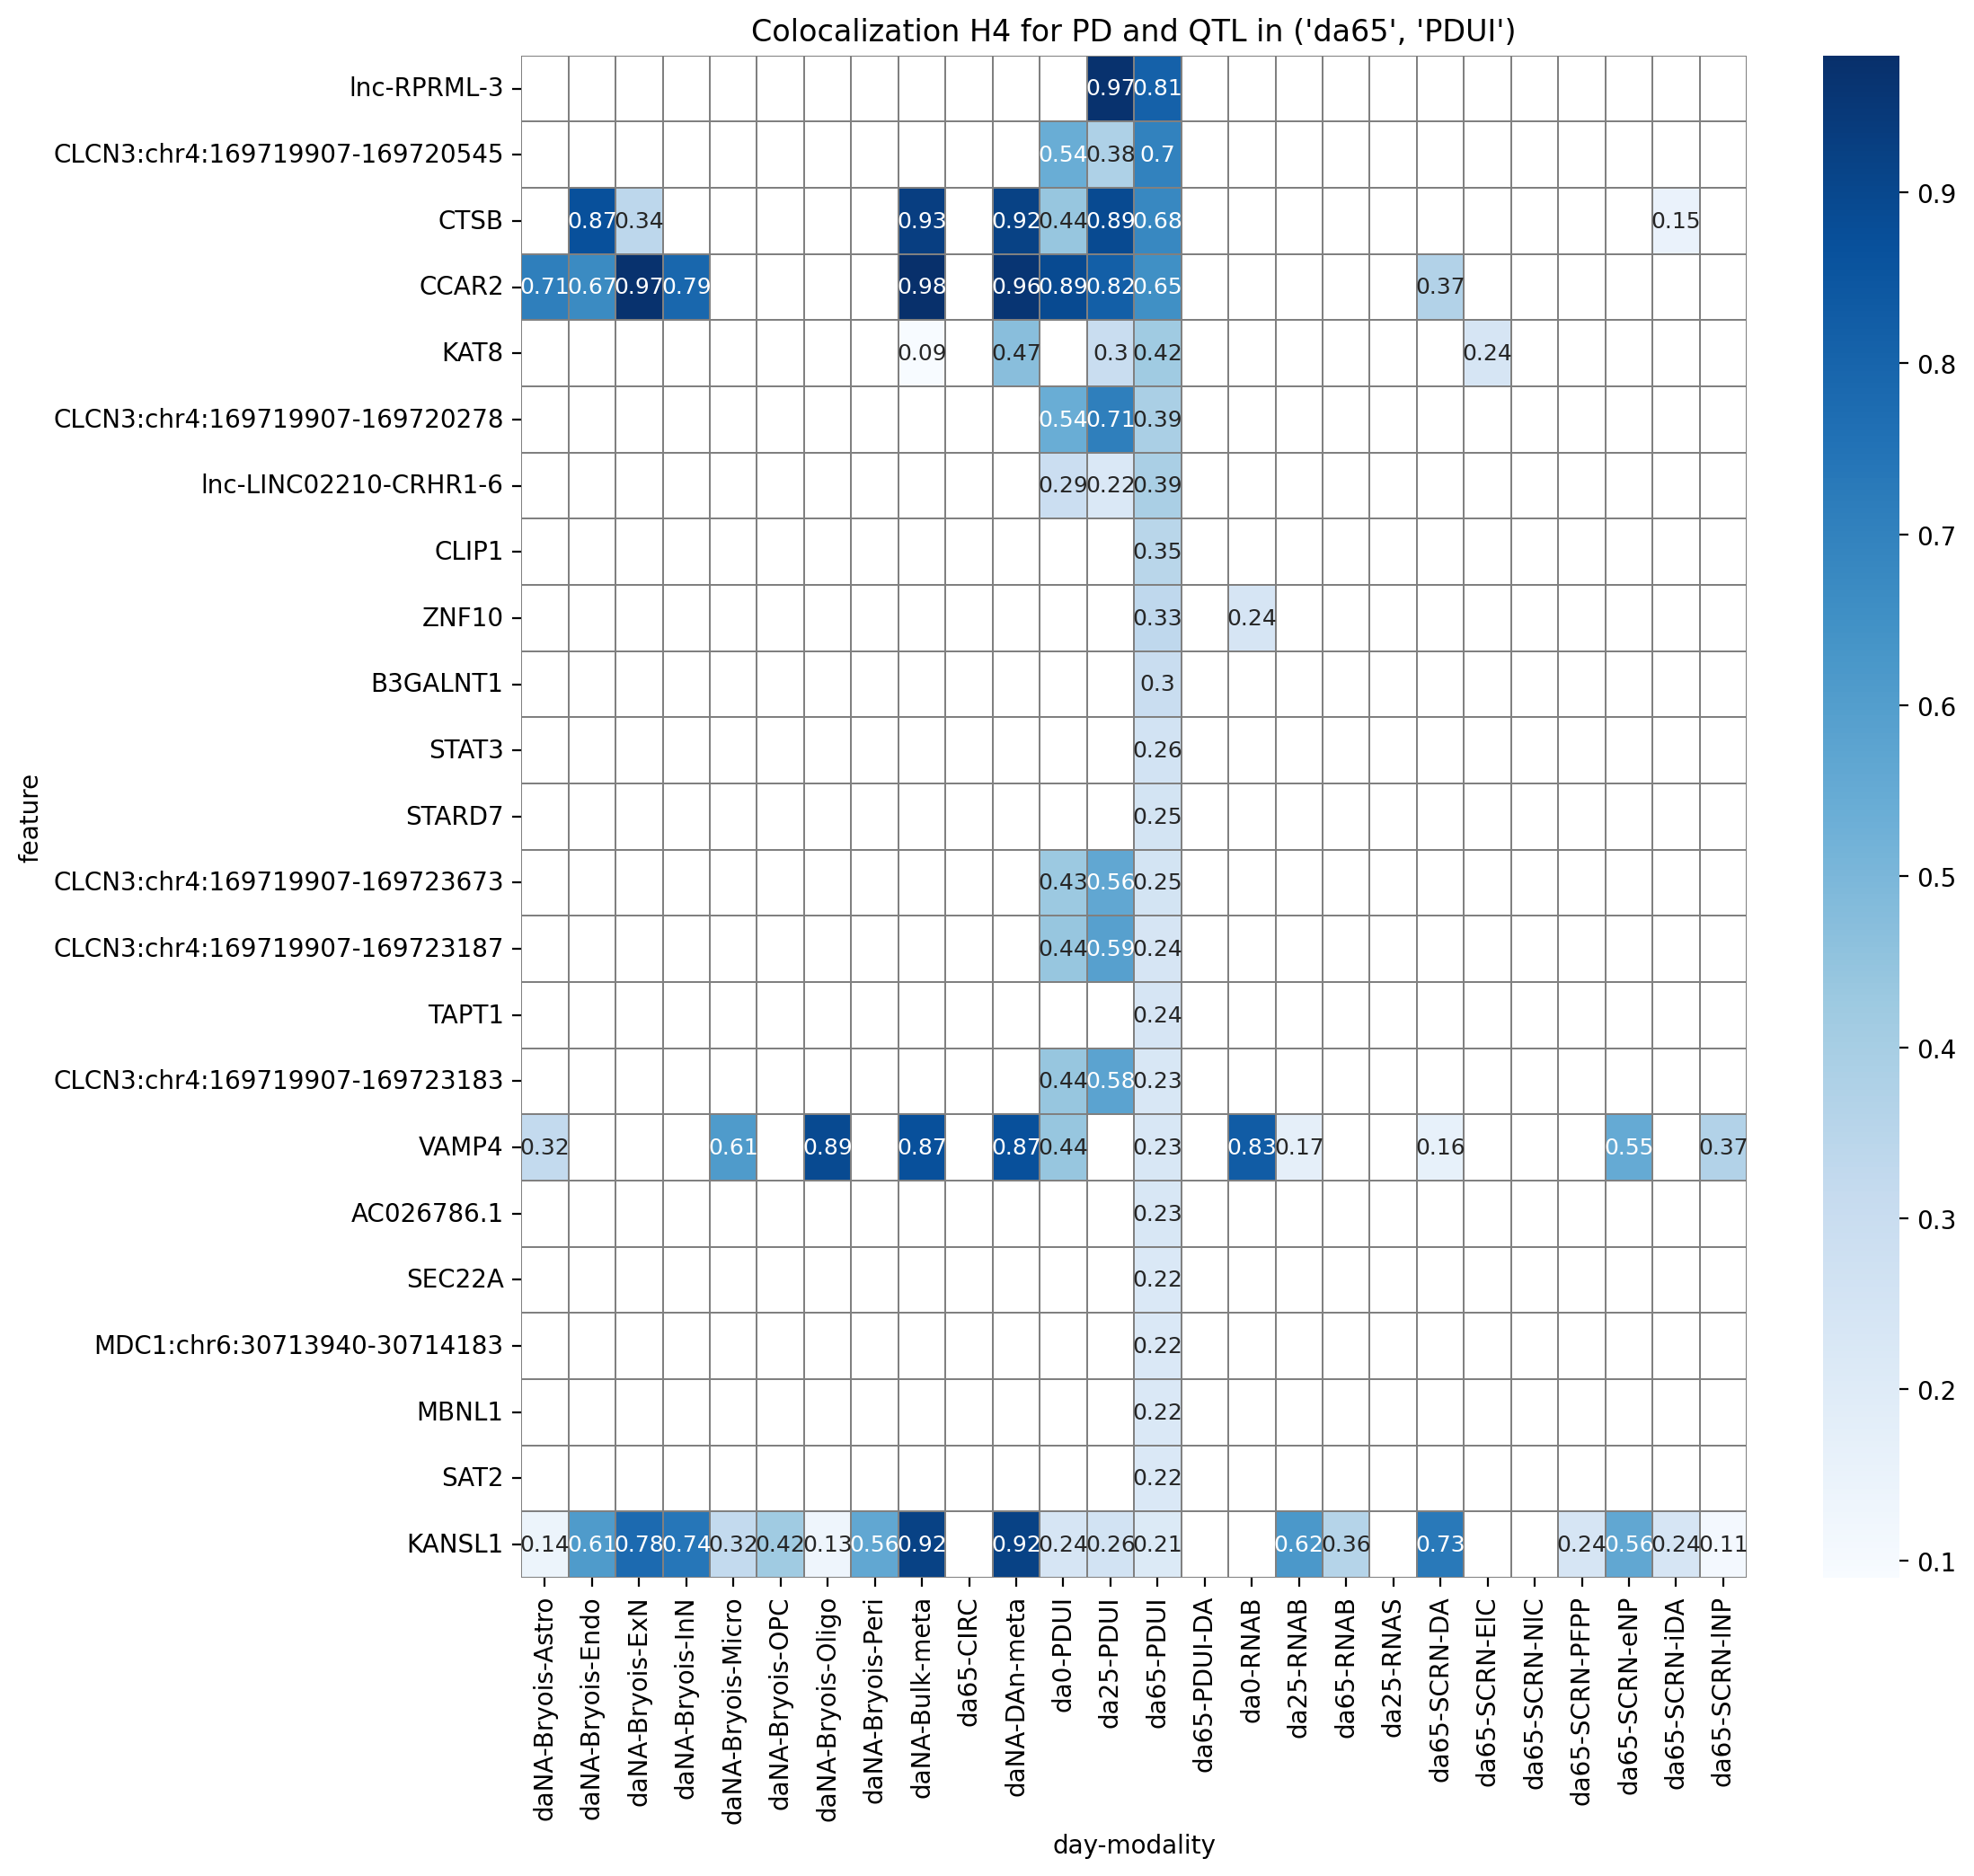

PDUI-DA
(2, 26)


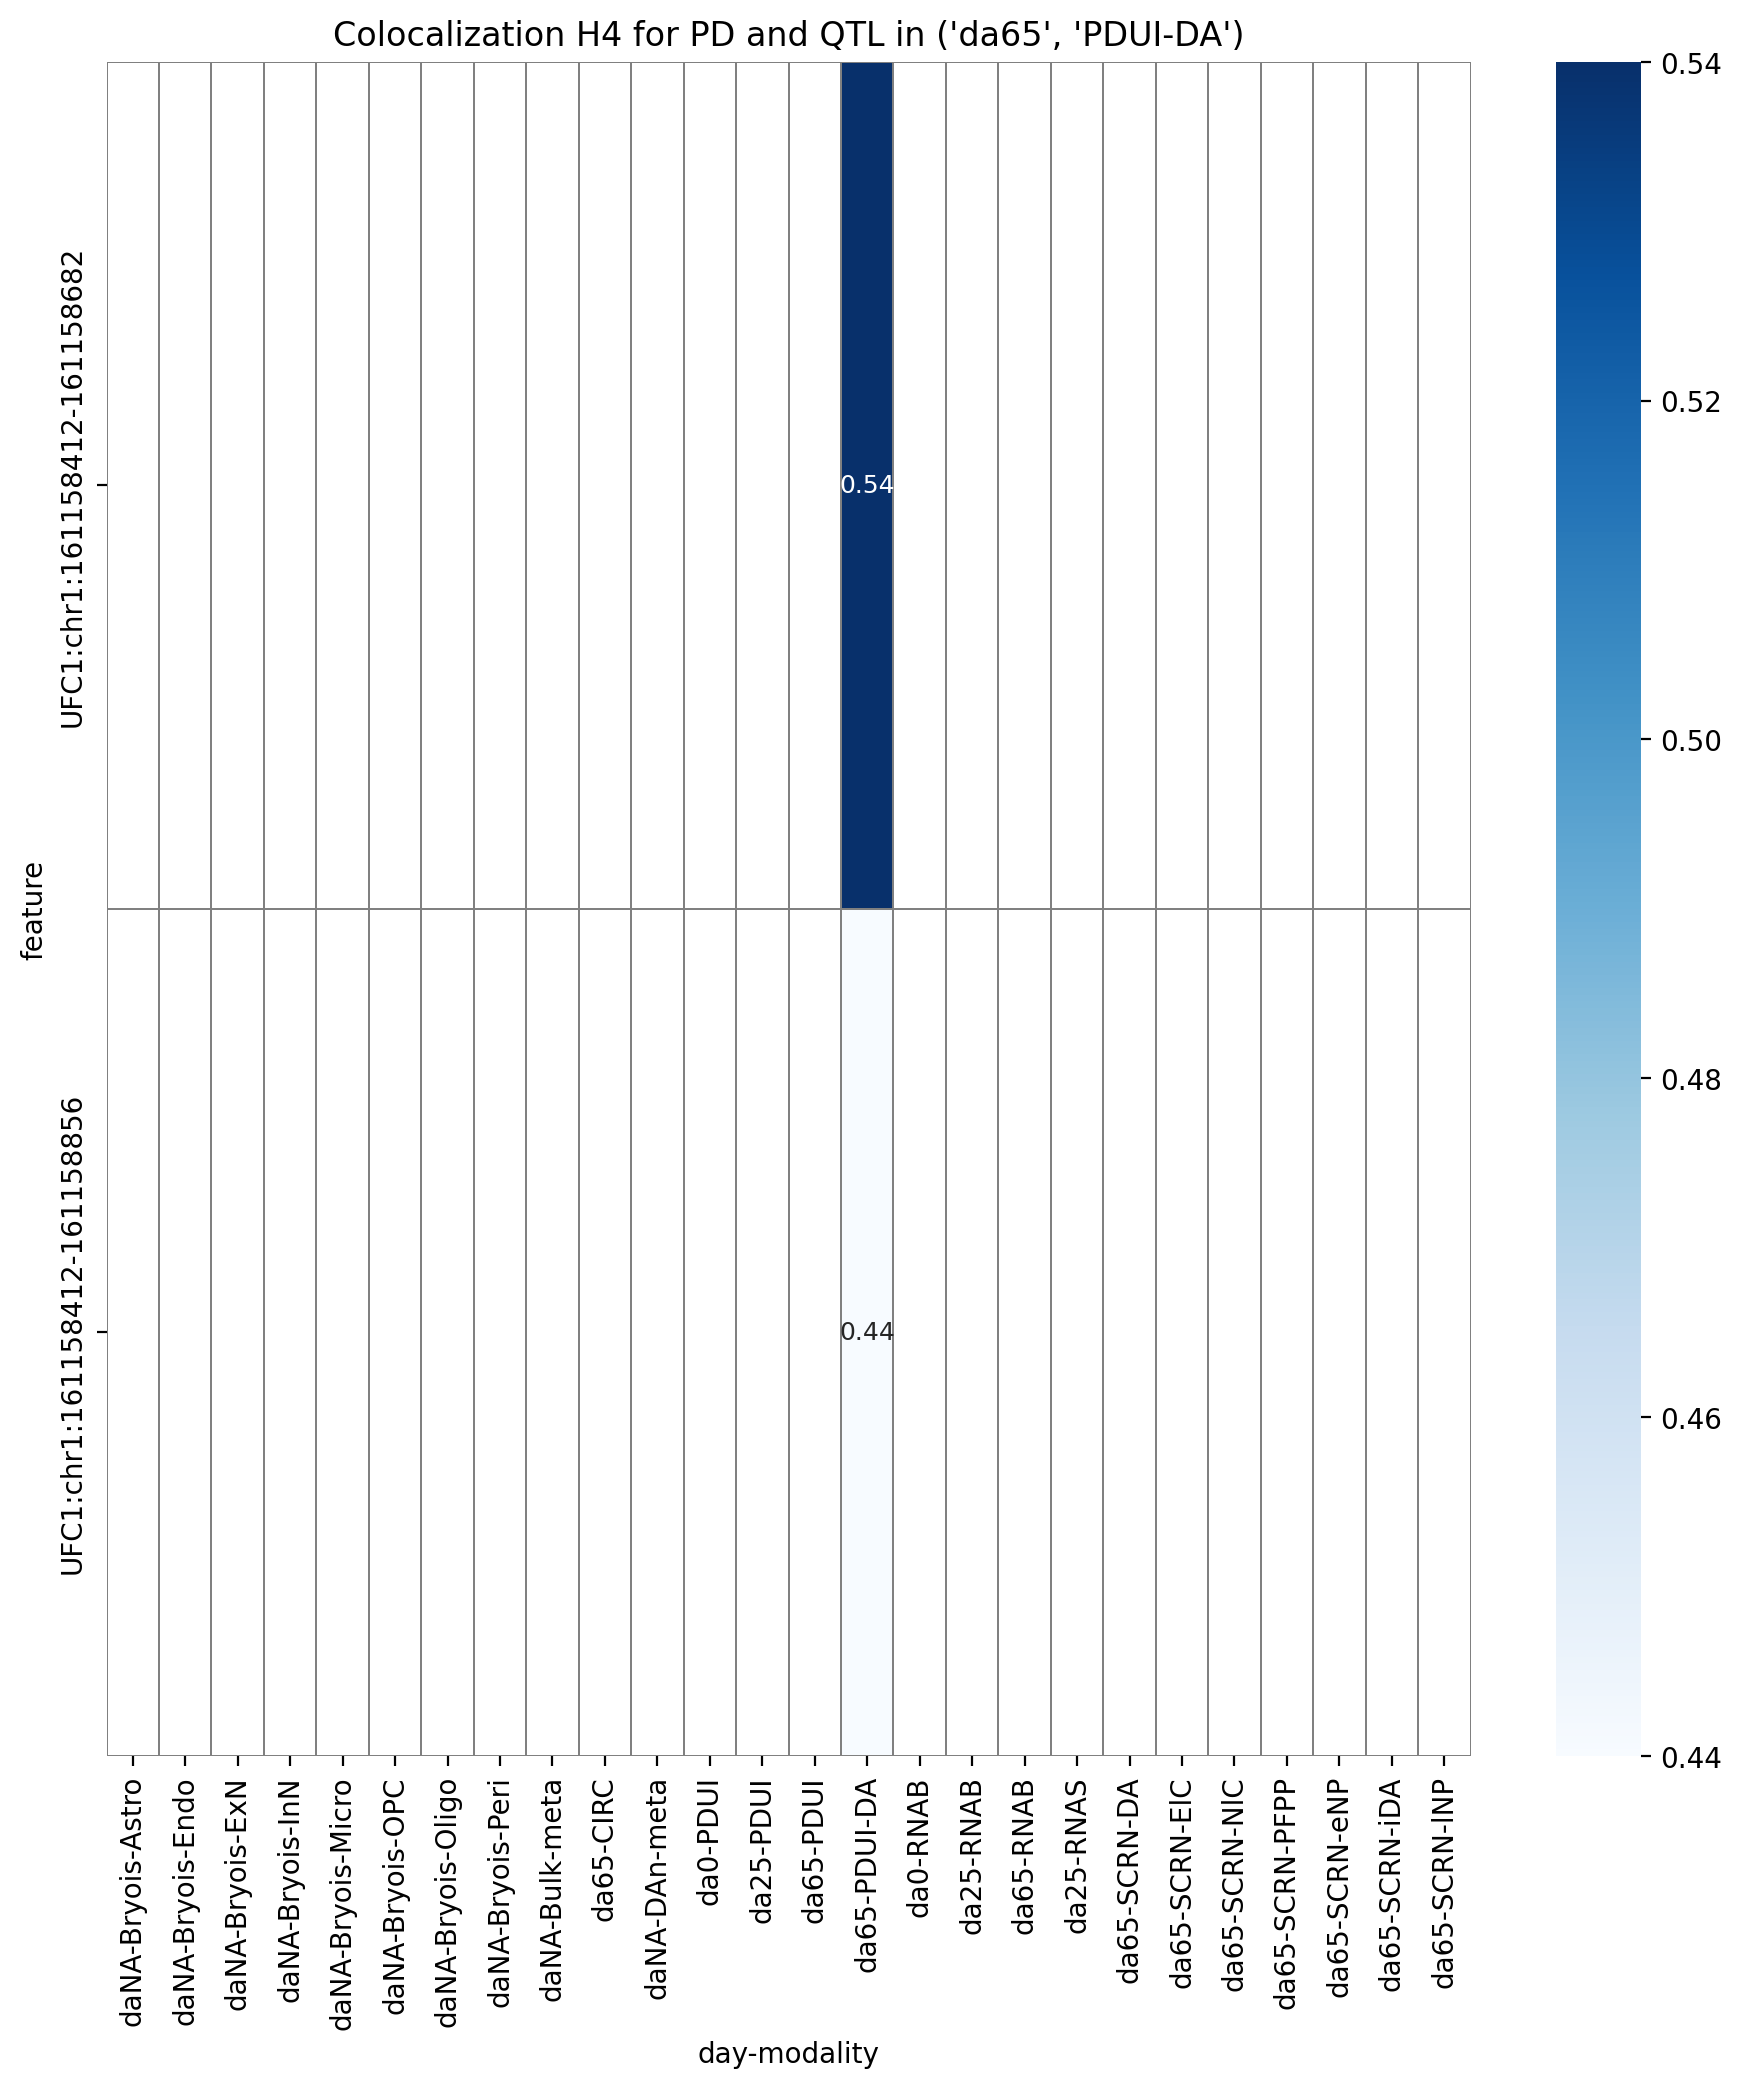

Bryois-ExN
(36, 26)


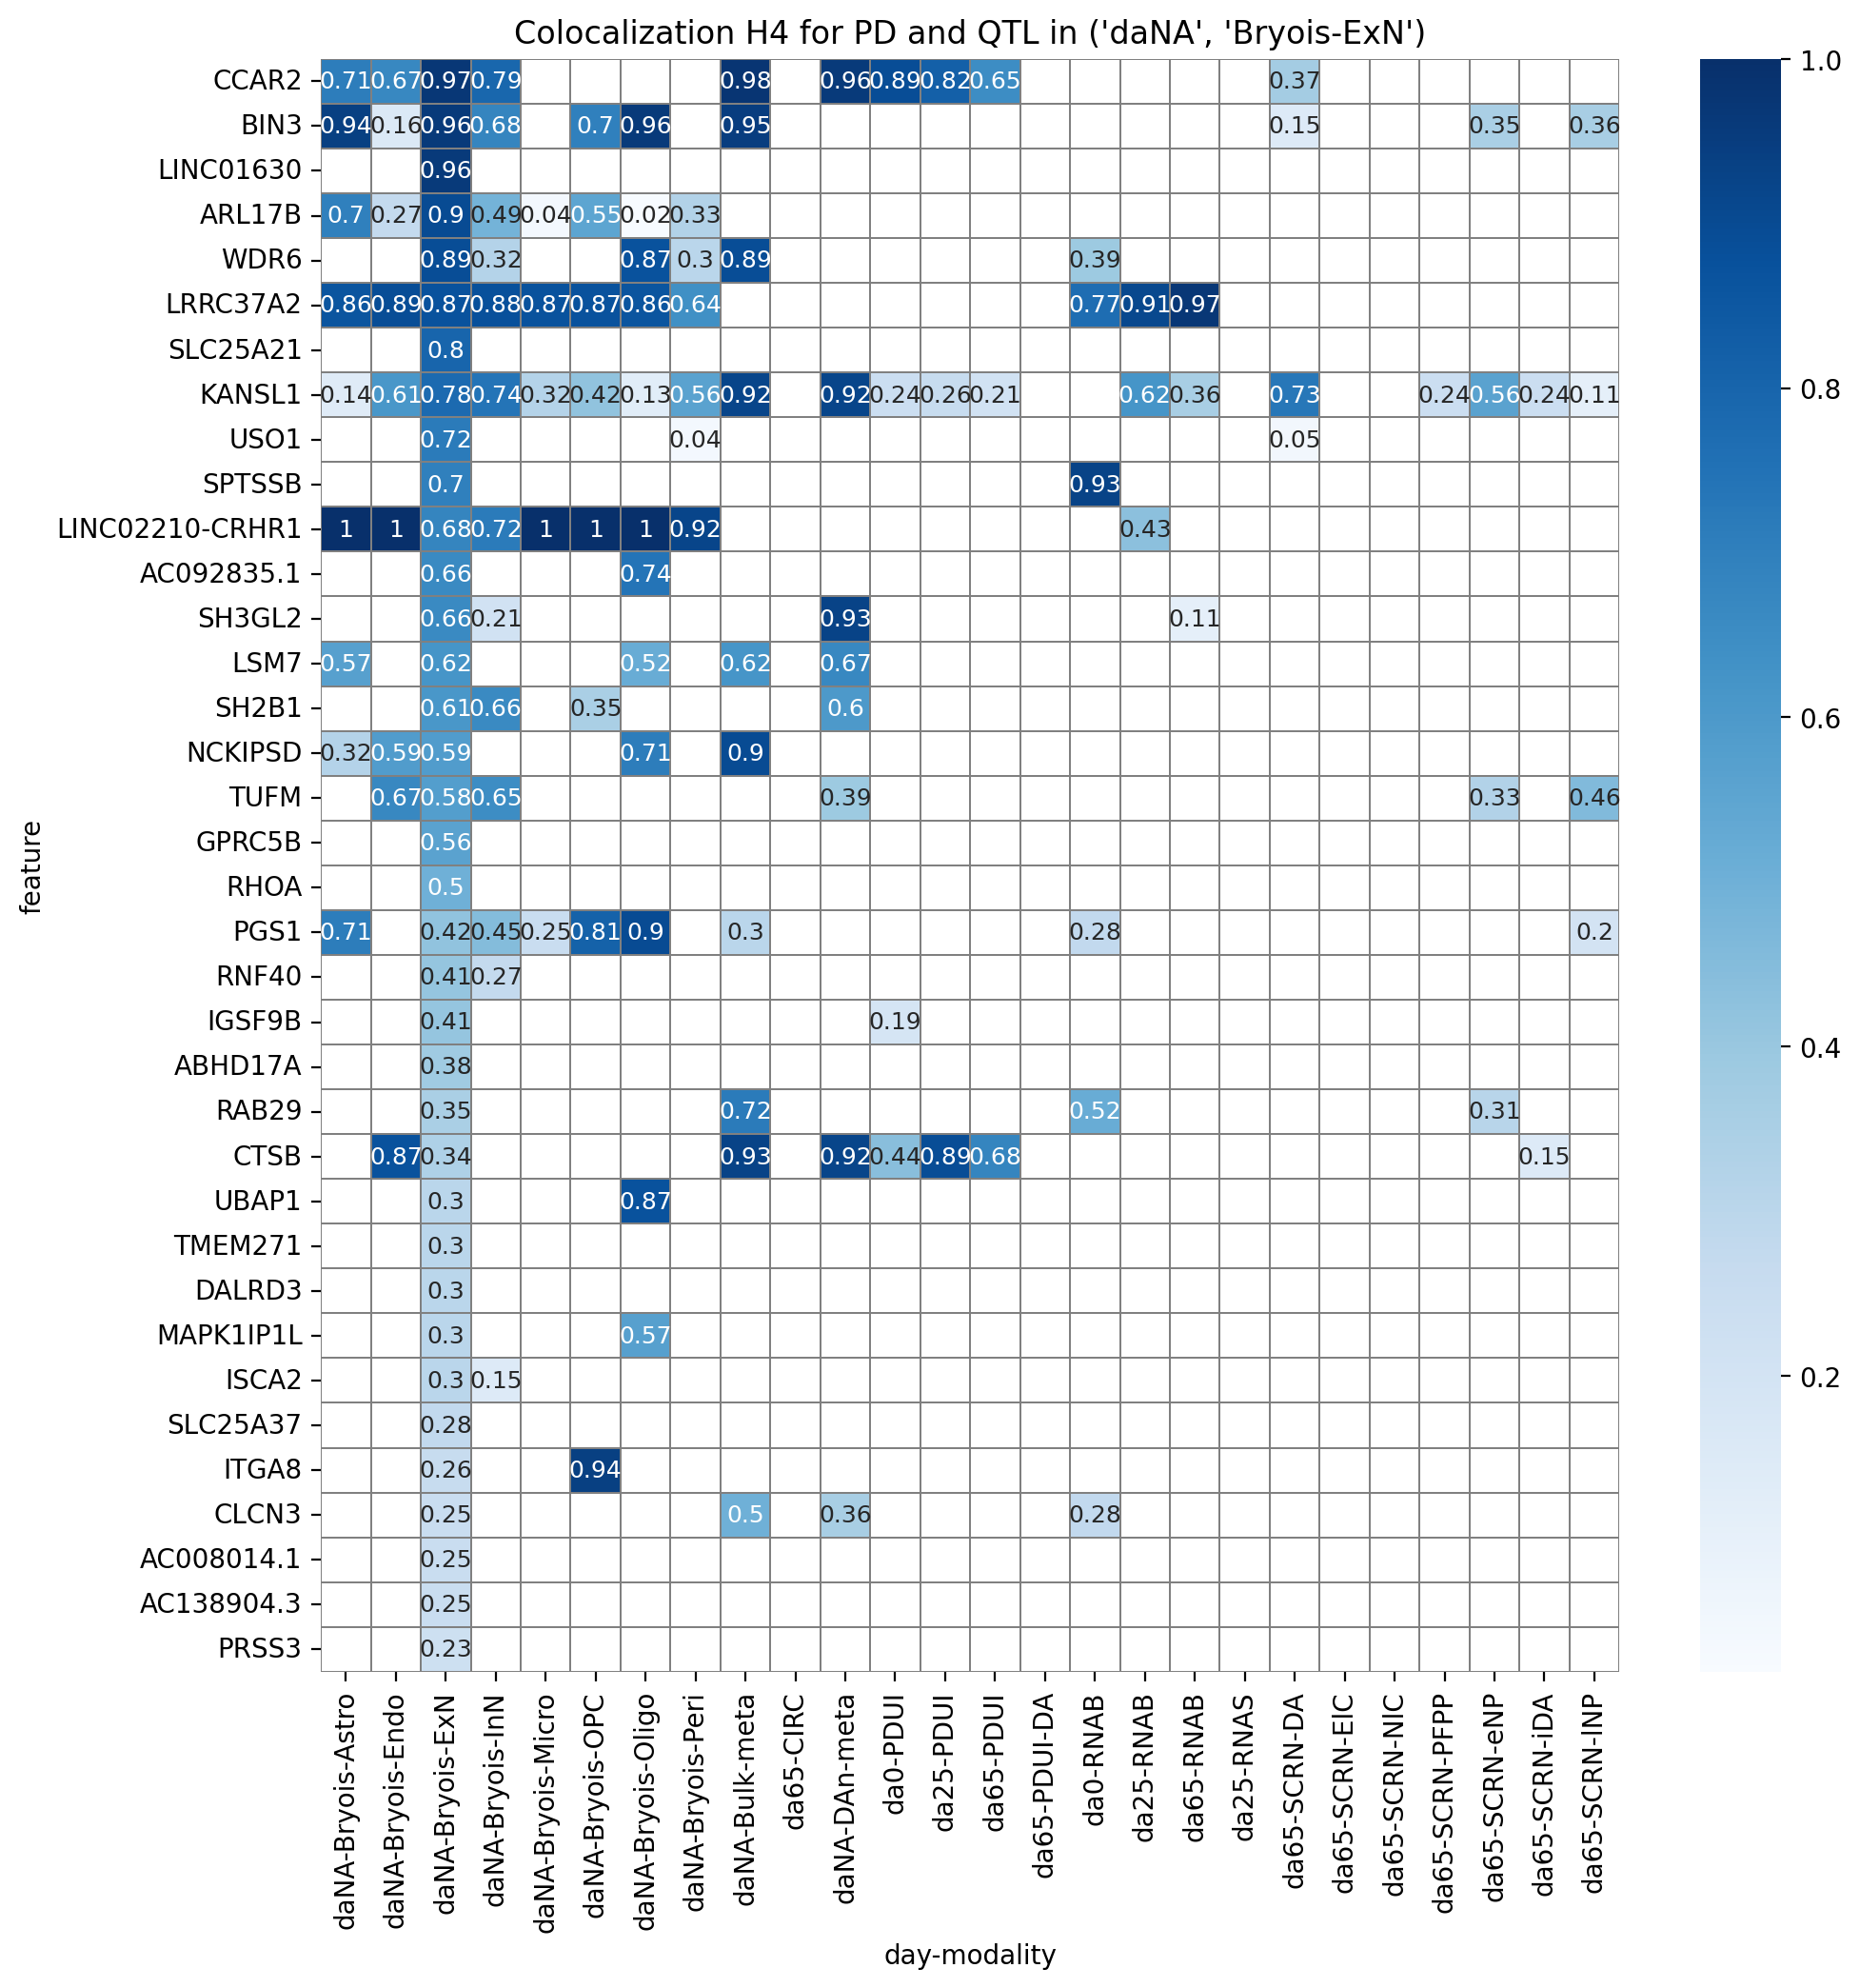

Bryois-InN
(31, 26)


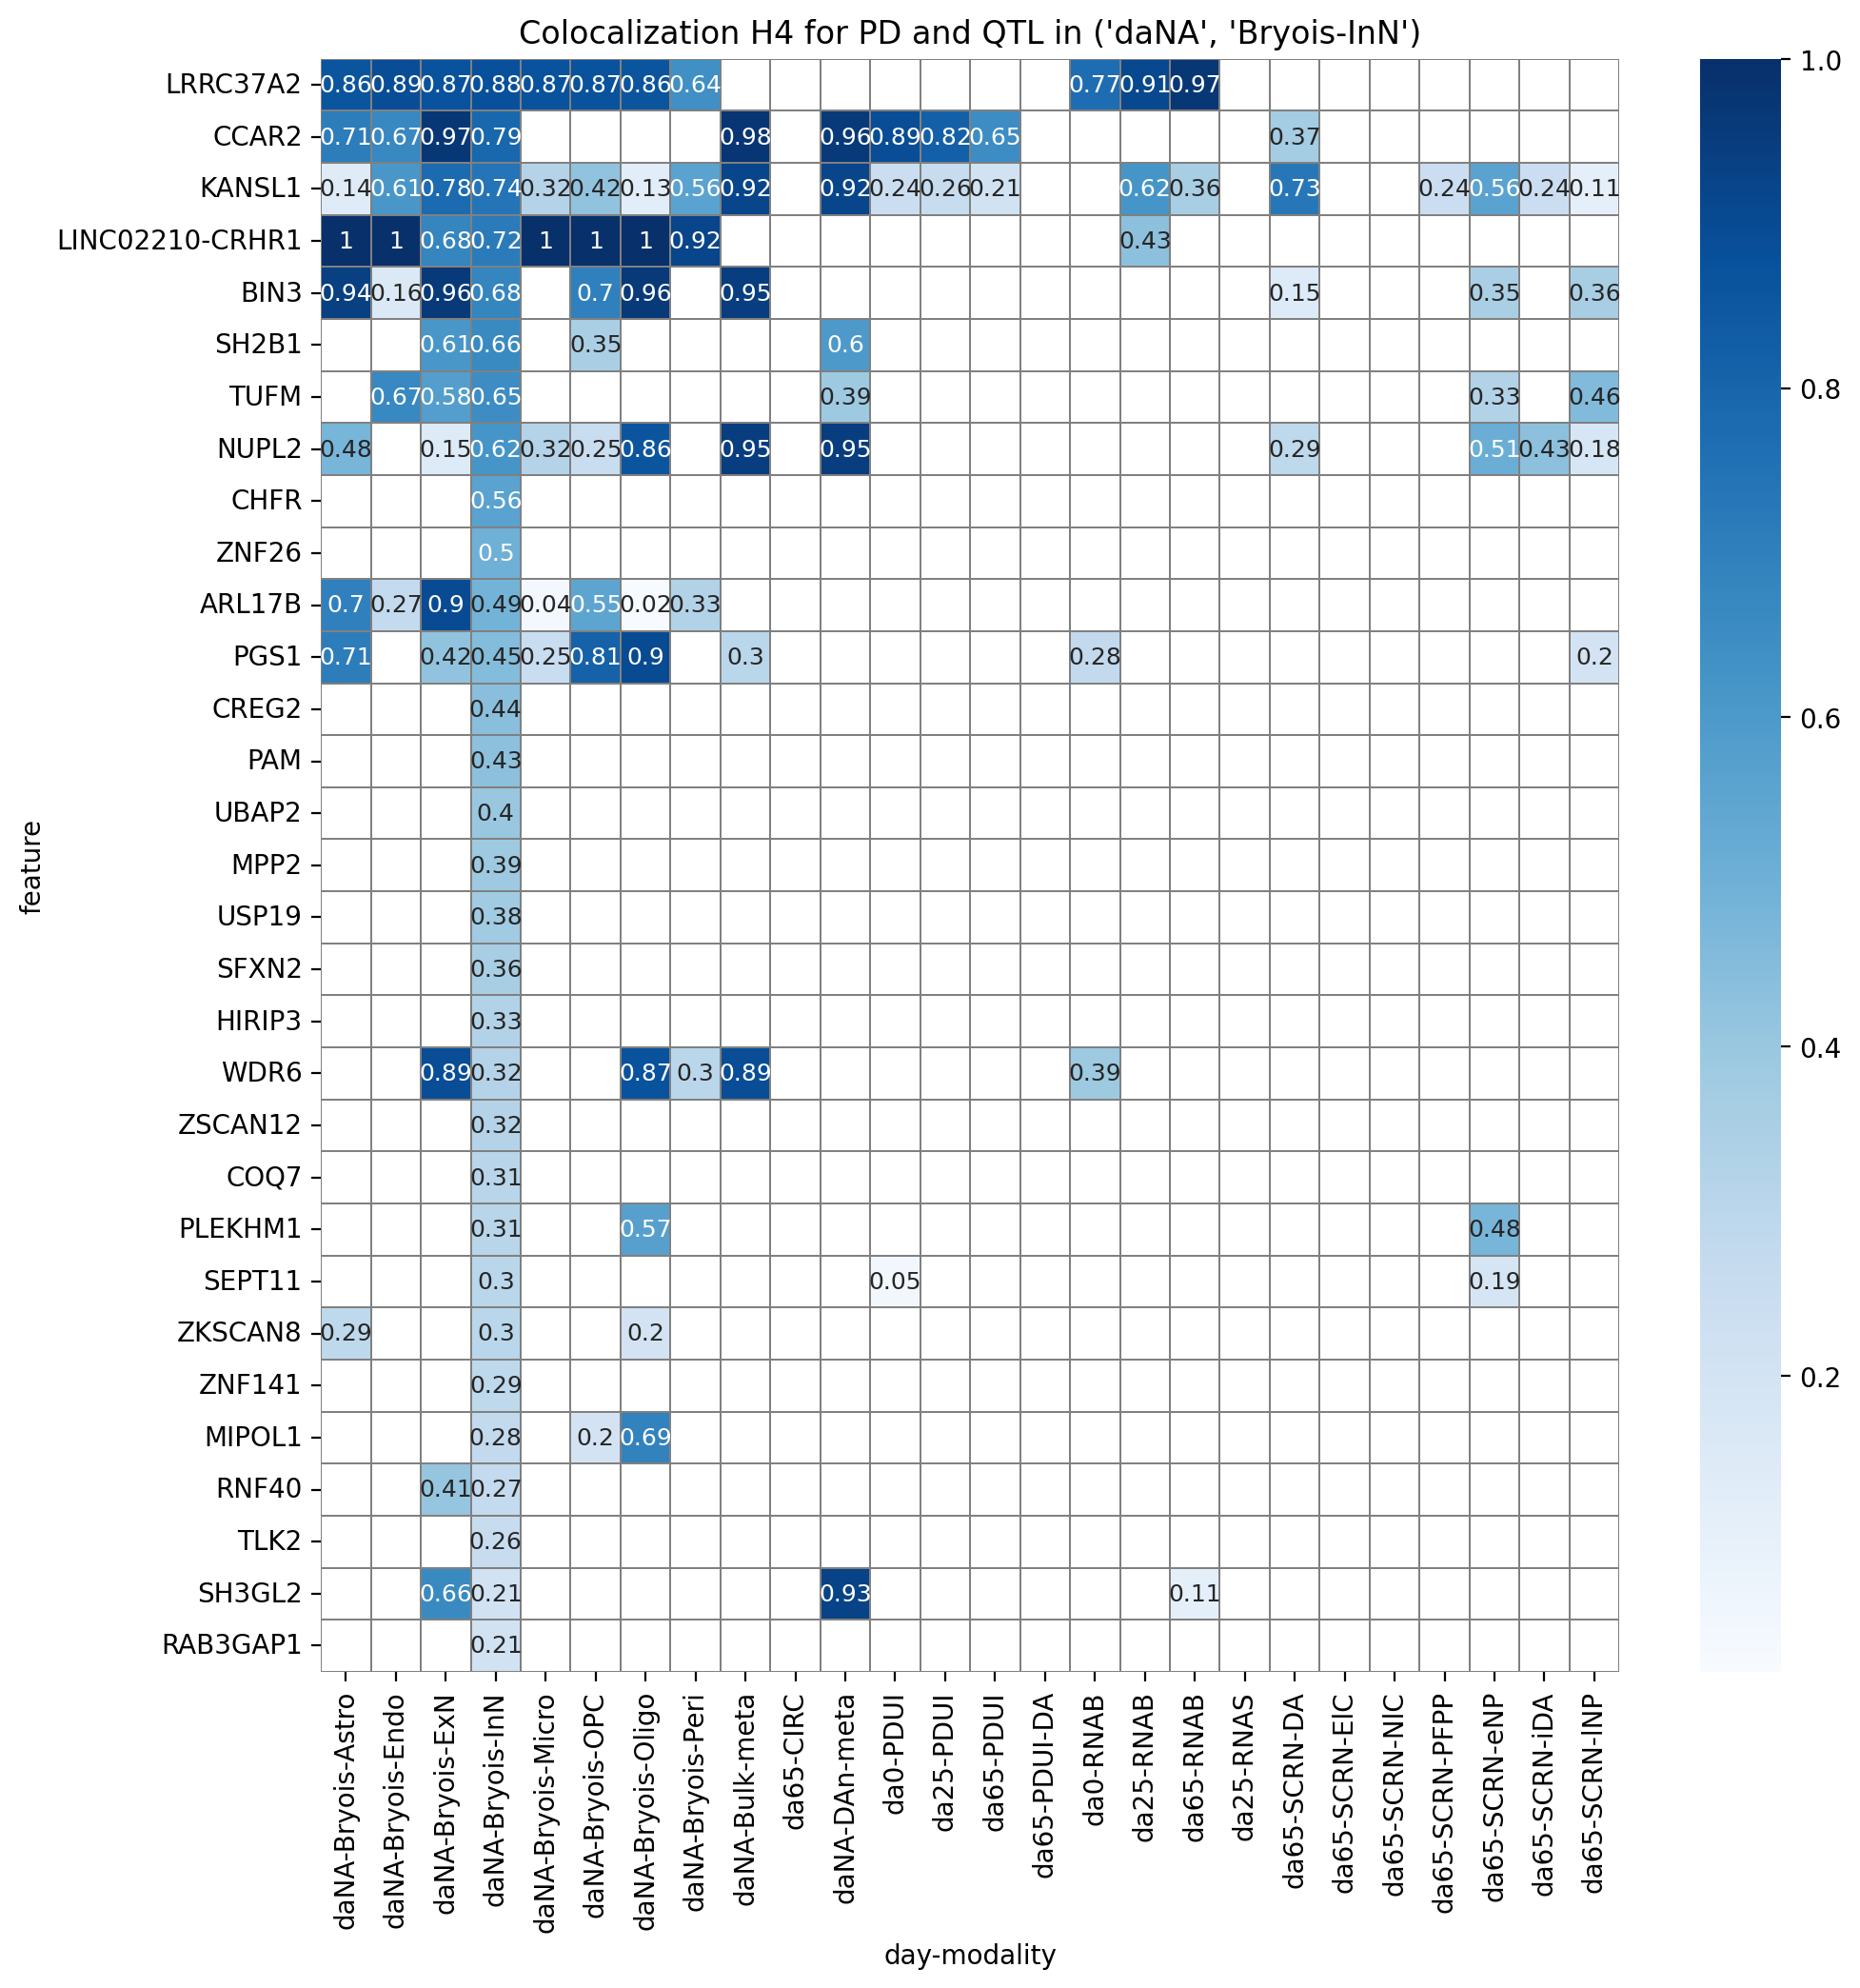

Bryois-Micro
(19, 26)


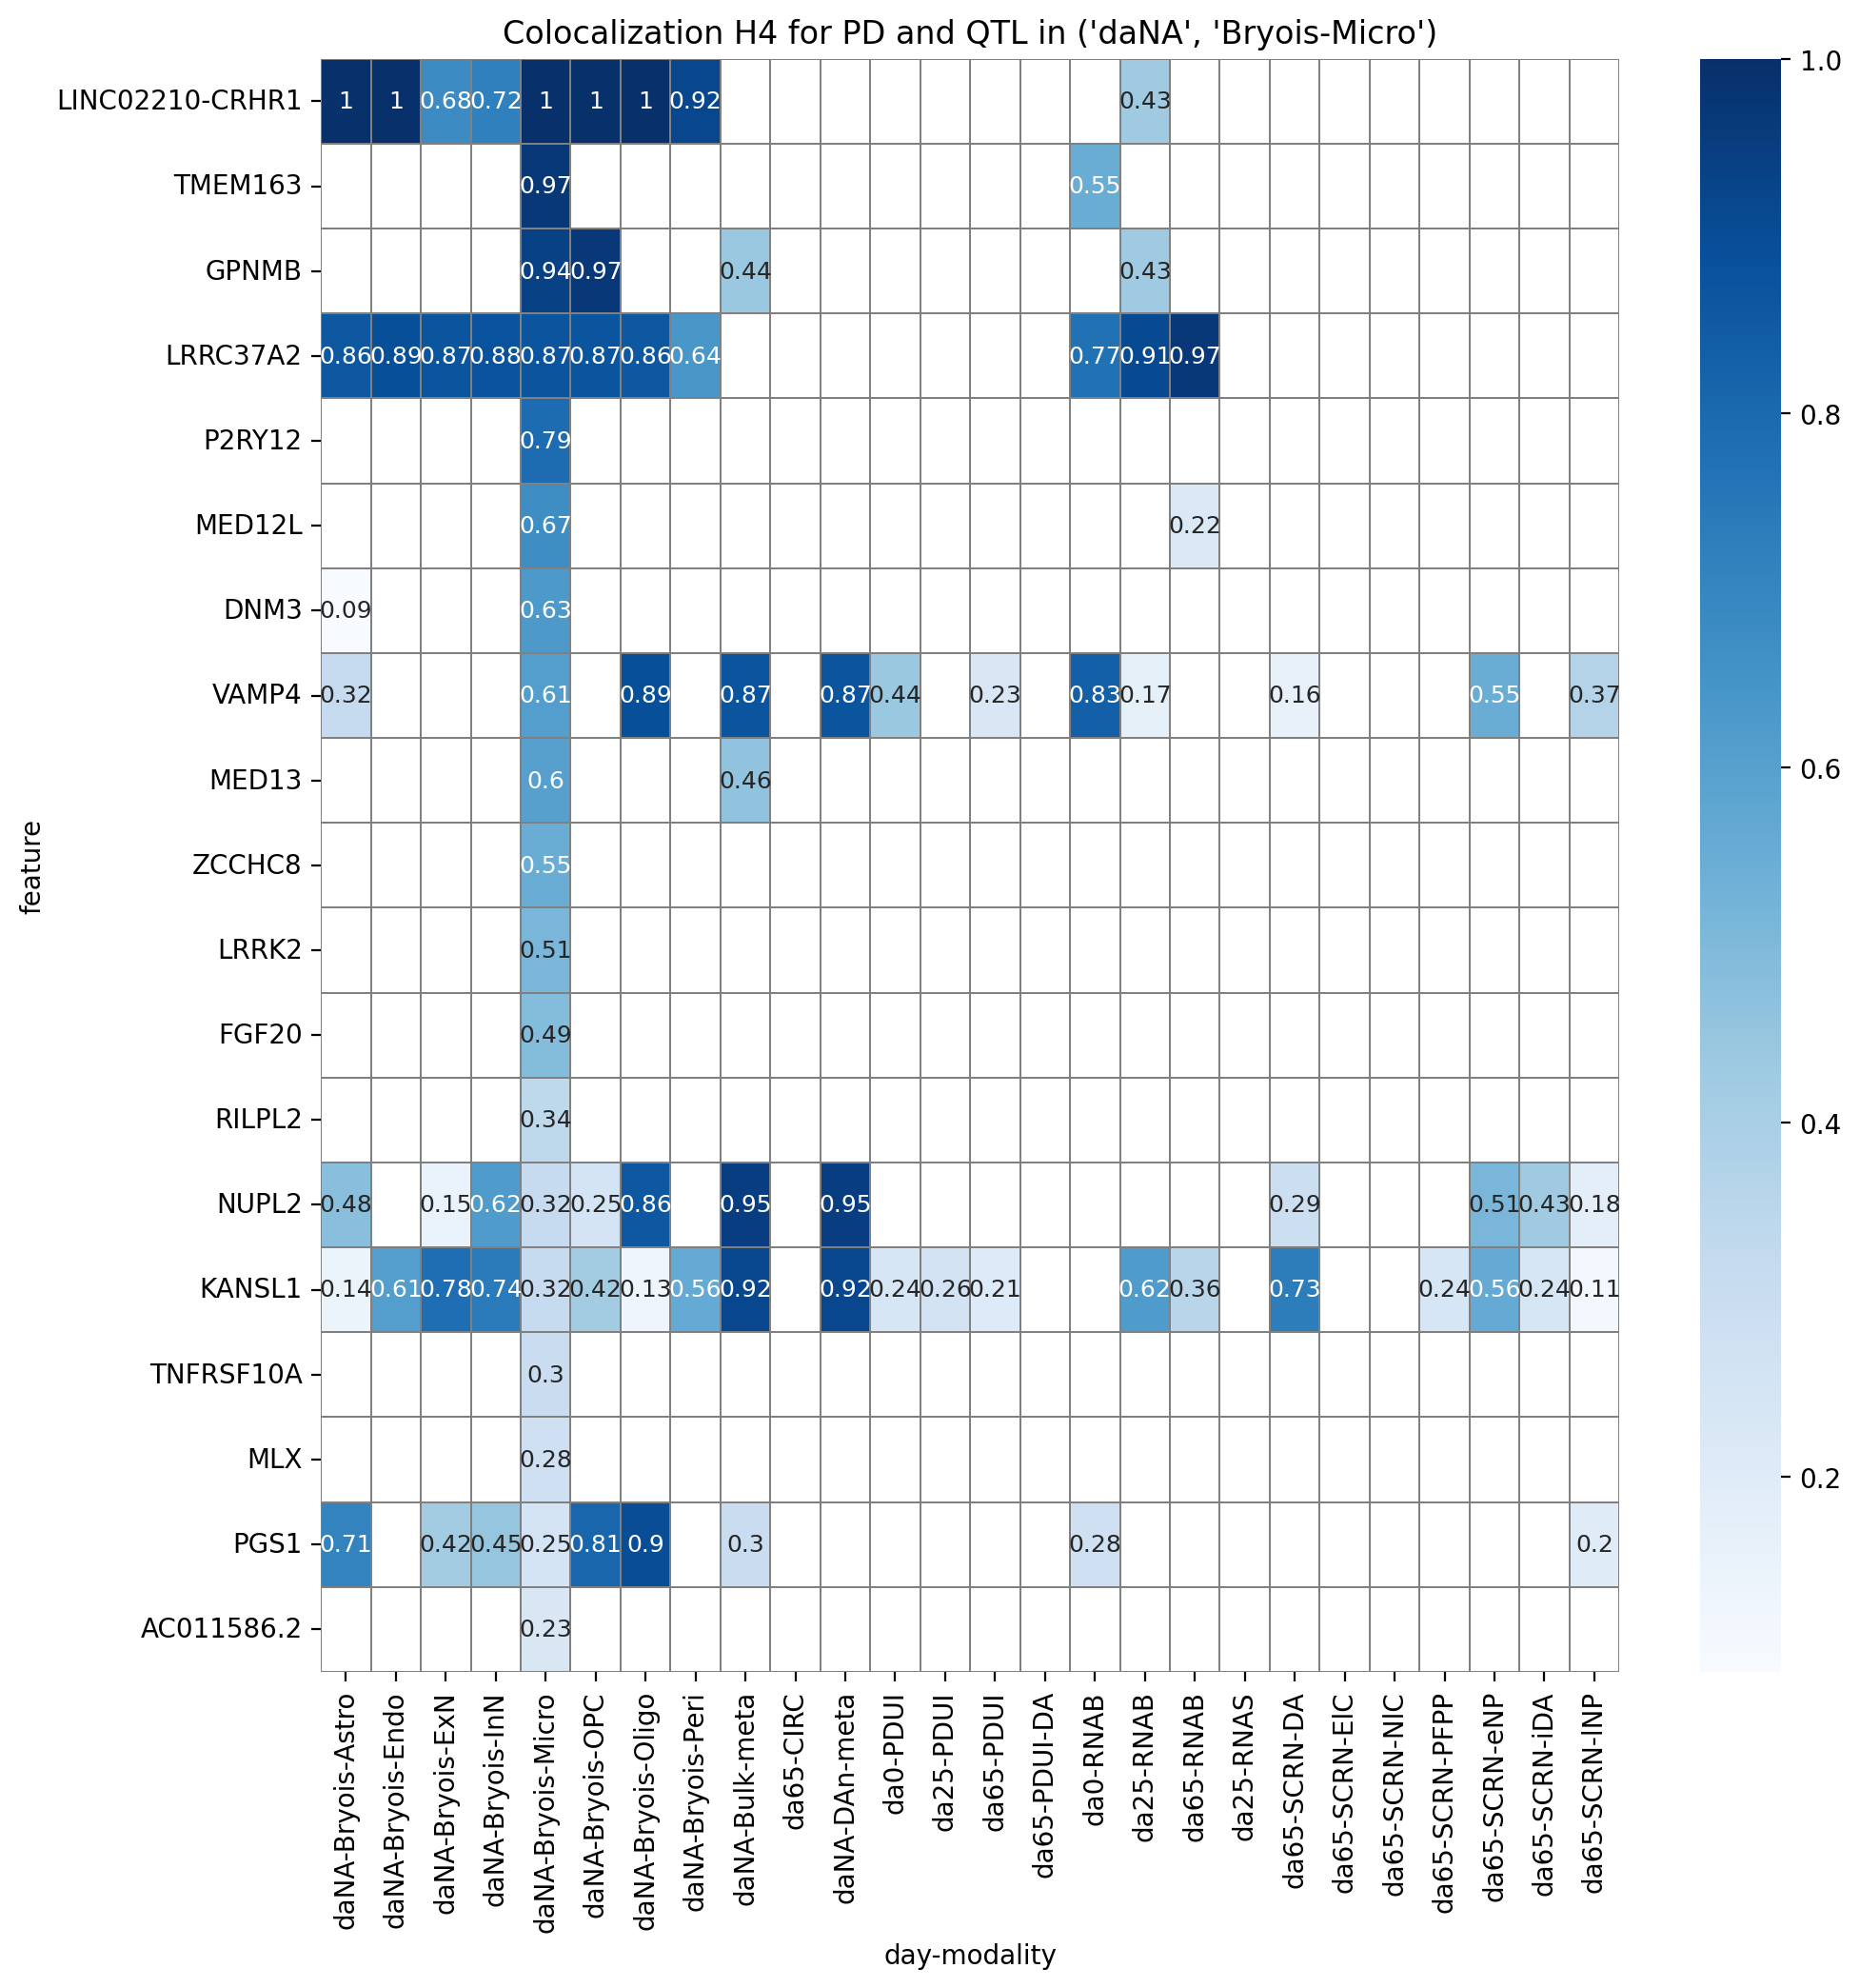

Bryois-Astro
(24, 26)


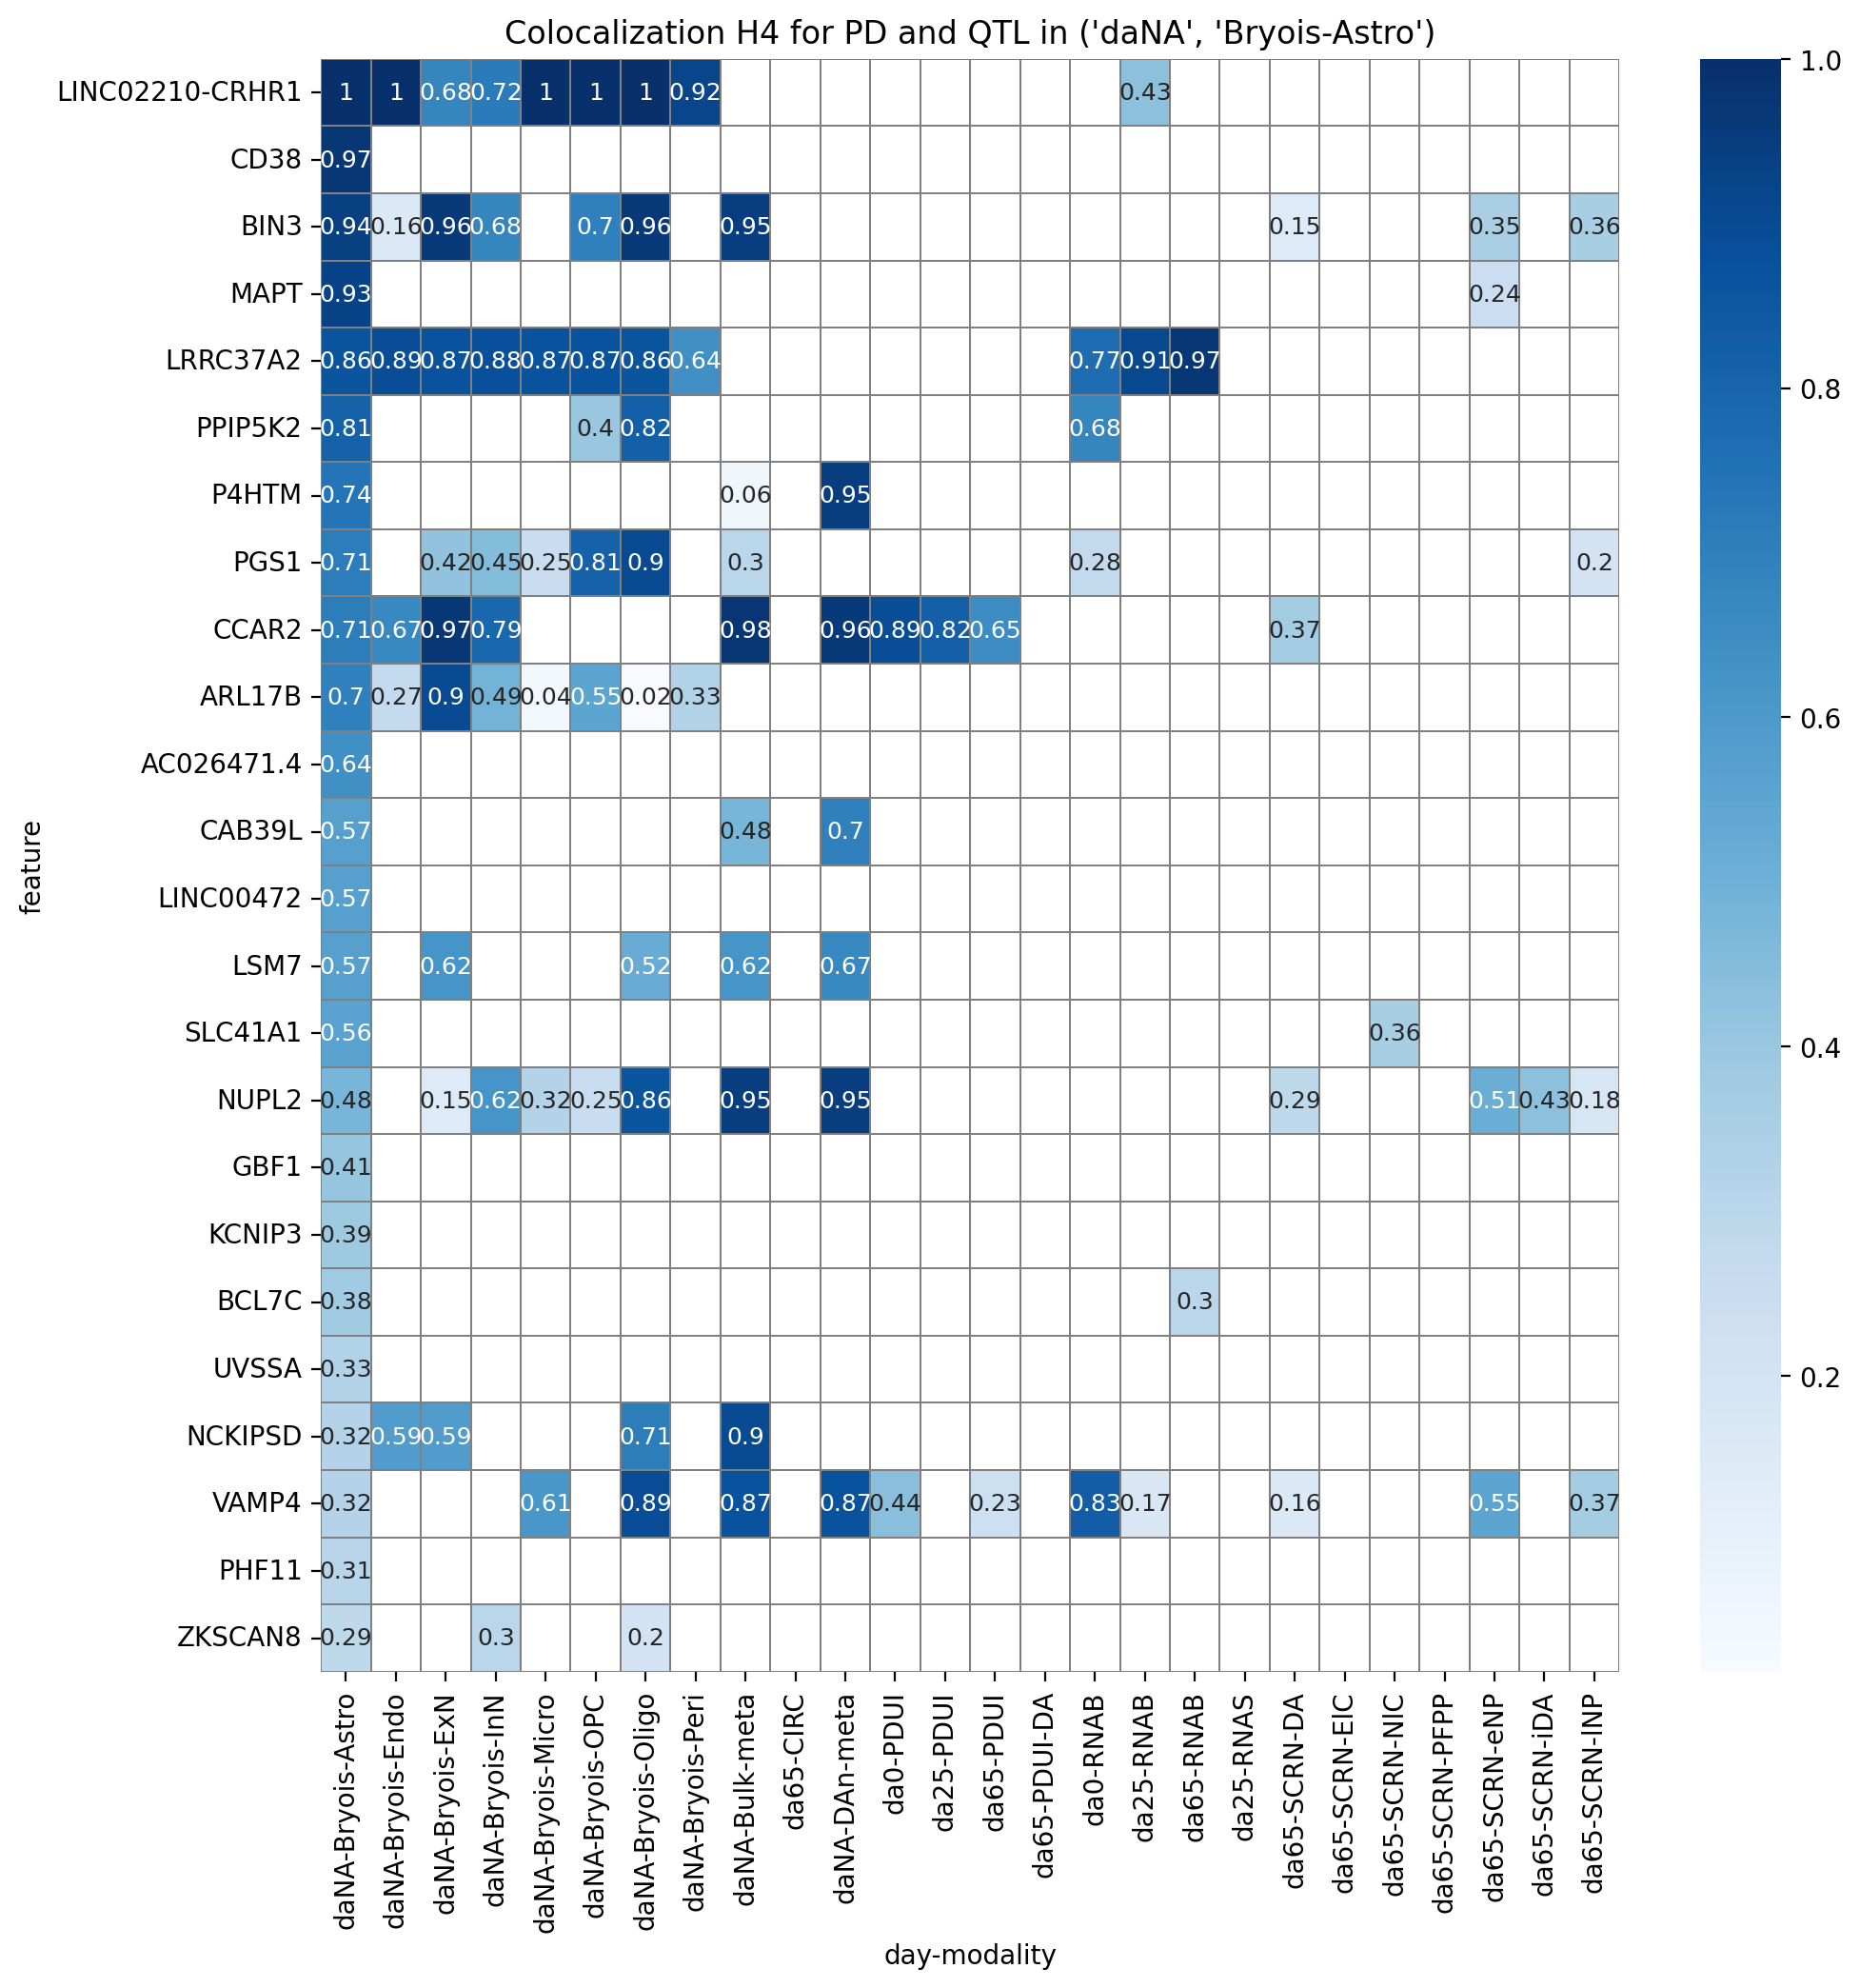

Bryois-Oligo
(24, 26)


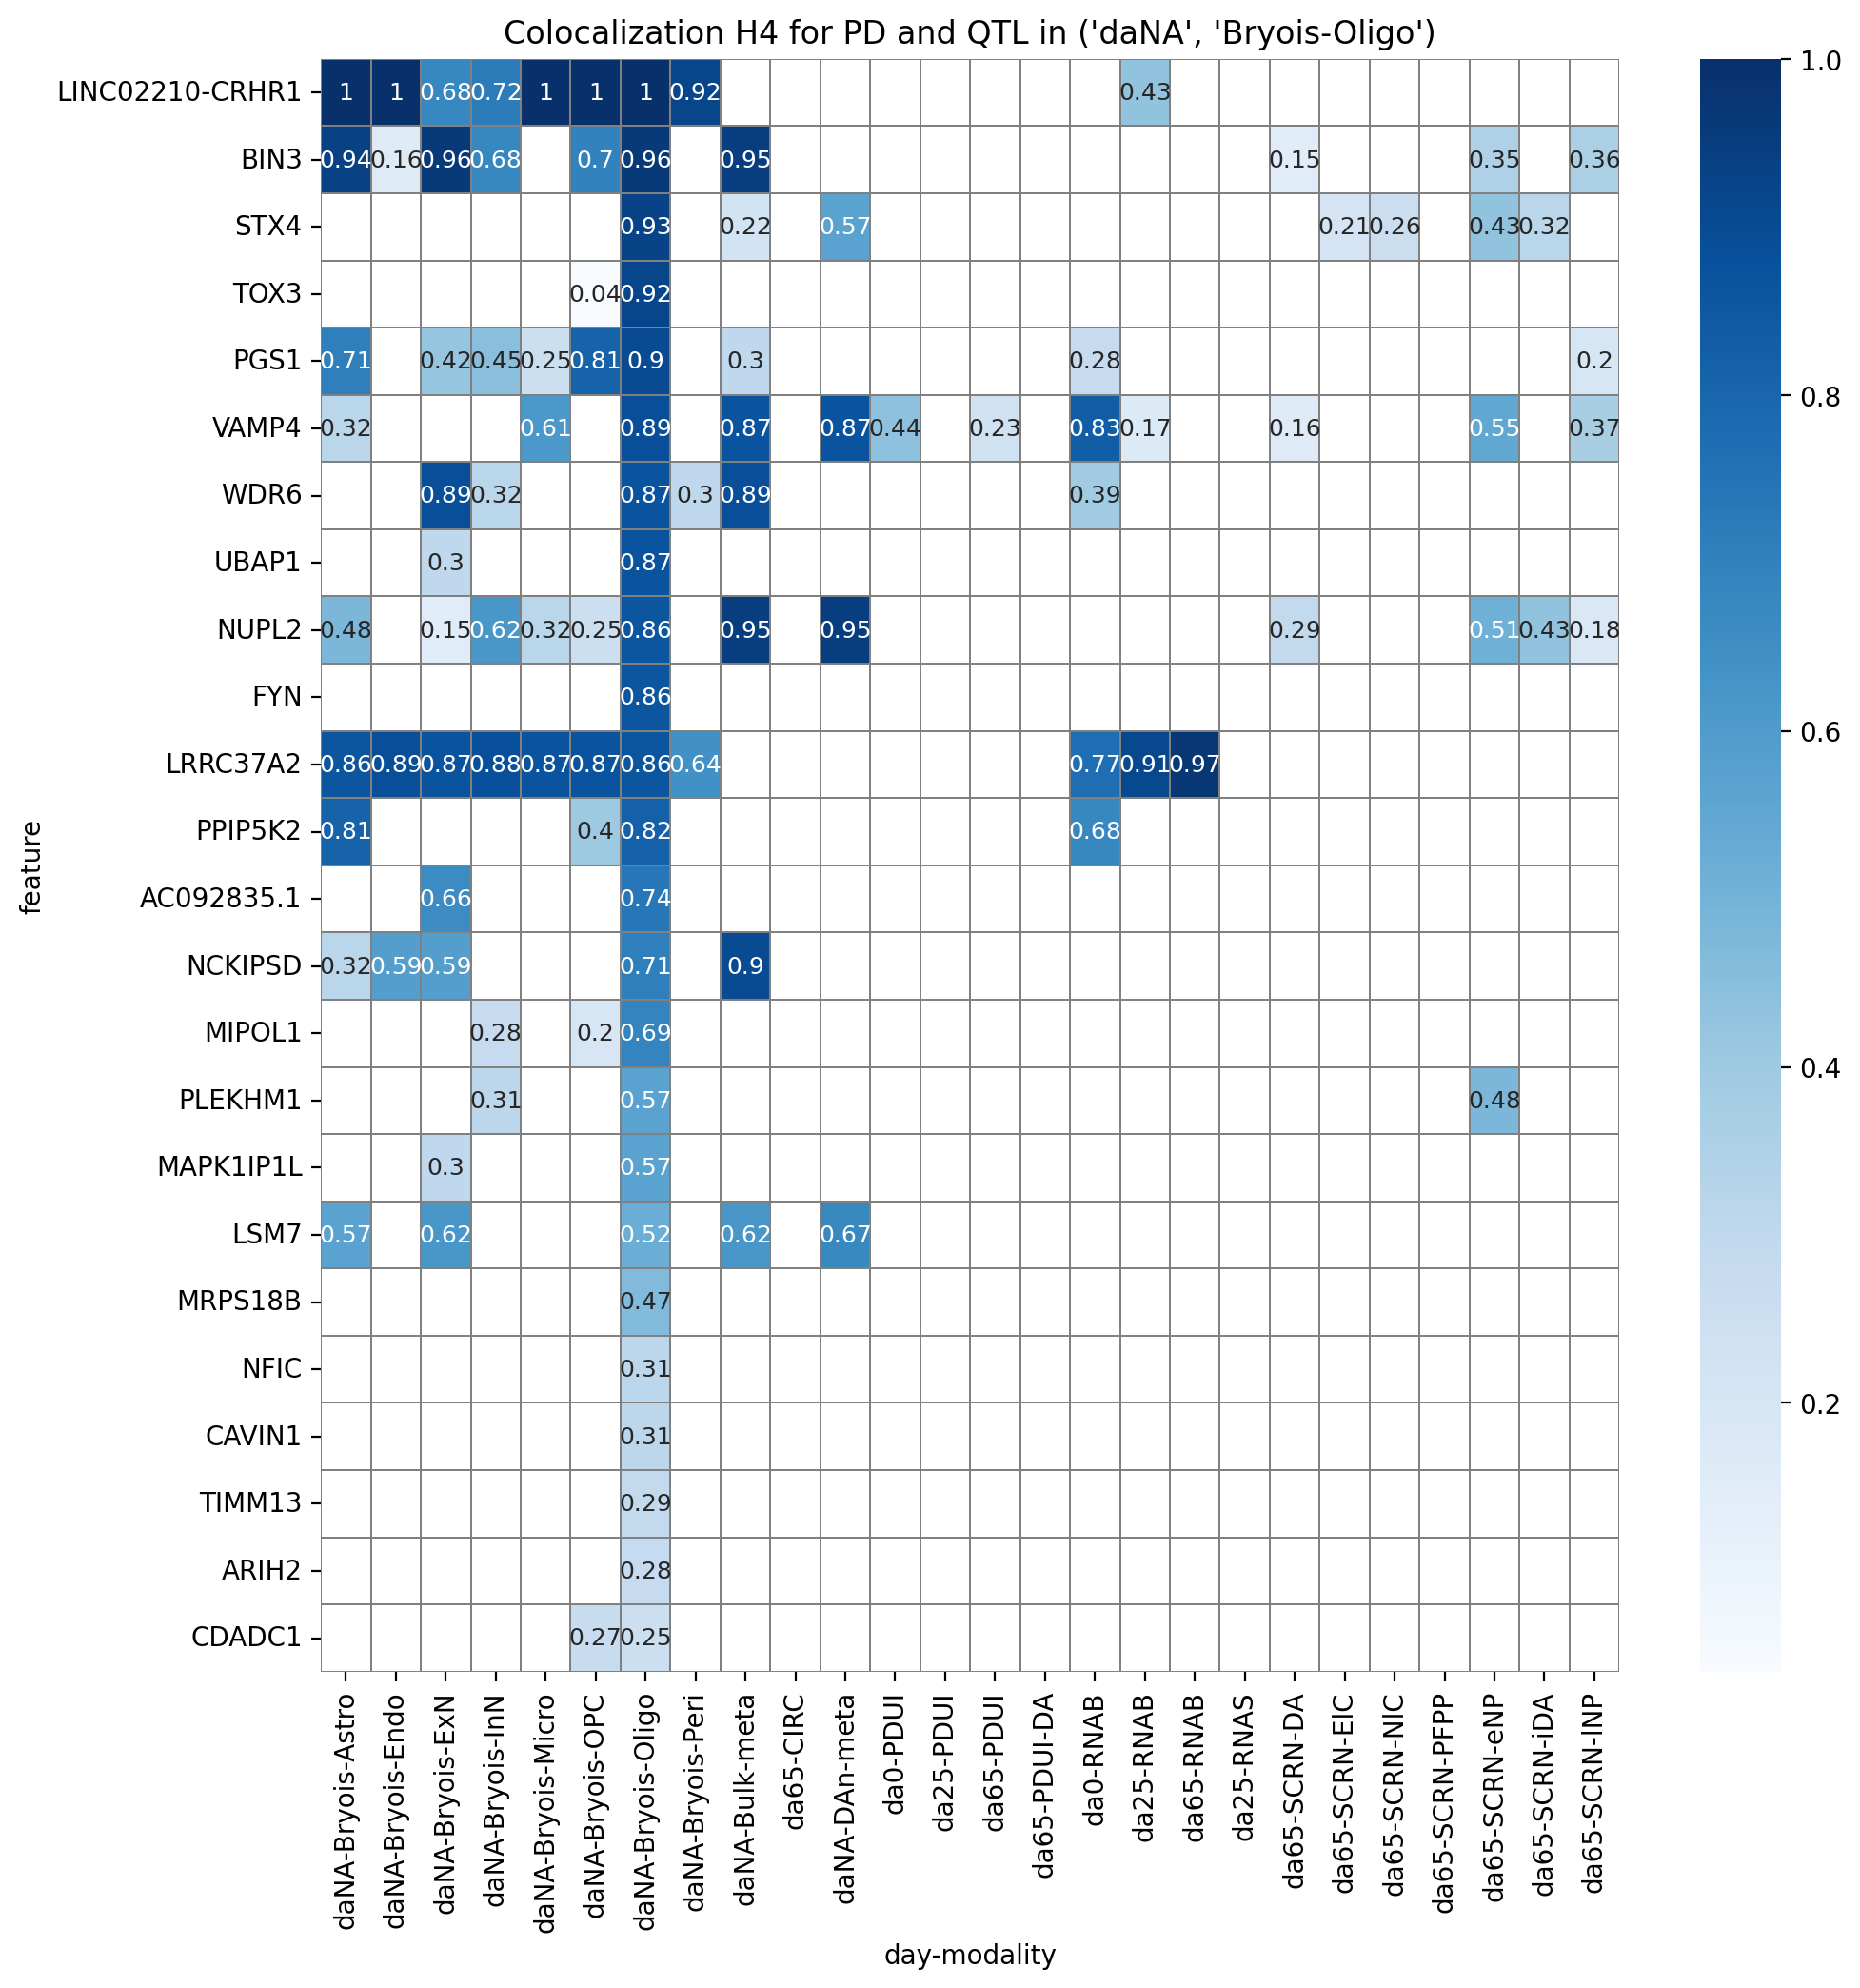

In [17]:
oi_modalities = [('daNA', 'DAn-meta'), ('daNA', 'Bulk-meta'), 
                 ('da65', 'PDUI'), ('da65', 'PDUI-DA'),
                 ('daNA', 'Bryois-ExN'), ('daNA', 'Bryois-InN'), 
                 ('daNA', 'Bryois-Micro'), ('daNA', 'Bryois-Astro'), 
                 ('daNA', 'Bryois-Oligo')]
for modality in oi_modalities:
    print(modality[1])
    temp_df = wcoloc_df.loc[wcoloc_df[modality] > min_h4].sort_values(modality, ascending=False)
    # sort by foundin DA neuron results
    temp_df = temp_df.sort_values(by=[modality], ascending=False)
    print(f'{temp_df.shape}')
    sub_figure_file = f'{figures_dir}/{cohort}.colocalization.{dx}.{modality[1]}.png'
    with rc_context({'figure.figsize': (11, 11), 'figure.dpi': dpi_value}):
        plt.style.use('seaborn-bright')    
        heatmap(temp_df, annot=True, linecolor='grey',
                annot_kws={"fontsize":9}, linewidths=0.05, cmap='Blues')    
        plt.title(f'Colocalization H4 for {dx} and QTL in {modality}')
        plt.savefig(sub_figure_file, dpi=dpi_value, bbox_inches='tight', 
                    transparent=True, pad_inches=1)
        plt.show()    

### print features with above threshold H4 by modalities of interest

In [18]:
oi_modalities = [('daNA', 'DAn-meta'), ('daNA', 'Bulk-meta'), 
                 ('da65', 'PDUI'), ('da65', 'PDUI-DA'),
                 ('daNA', 'Bryois-ExN'), ('daNA', 'Bryois-InN'), 
                 ('daNA', 'Bryois-Micro'), ('daNA', 'Bryois-Astro'), 
                 ('daNA', 'Bryois-Oligo')]
for modality in oi_modalities:
    print(modality)
    temp = wcoloc_df.loc[wcoloc_df[modality] > min_h4].sort_values(modality, ascending=False)
    print(temp.index)
    display(temp[modality])

('daNA', 'DAn-meta')
Index(['CCAR2', 'P4HTM', 'NUPL2', 'RNF141', 'SH3GL2', 'KANSL1', 'CTSB',
       'STX1B', 'VAMP4', 'GRN', 'GCH1', 'CAB39L', 'LSM7', 'SH2B1', 'STX4',
       'CRLS1', 'KAT8', 'NMD3', 'SNCA', 'JAM3', 'KLHL7', 'TUFM', 'CLCN3',
       'COA3', 'CAMK2D', 'CHRNB1', 'MAEA', 'LGALS3', 'SLC25A39', 'CERS6'],
      dtype='object', name='feature')


feature
CCAR2       0.96
P4HTM       0.95
NUPL2       0.95
RNF141      0.94
SH3GL2      0.93
KANSL1      0.92
CTSB        0.92
STX1B       0.89
VAMP4       0.87
GRN         0.84
GCH1        0.73
CAB39L      0.70
LSM7        0.67
SH2B1       0.60
STX4        0.57
CRLS1       0.49
KAT8        0.47
NMD3        0.44
SNCA        0.42
JAM3        0.39
KLHL7       0.39
TUFM        0.39
CLCN3       0.36
COA3        0.33
CAMK2D      0.31
CHRNB1      0.30
MAEA        0.30
LGALS3      0.28
SLC25A39    0.27
CERS6       0.27
Name: (daNA, DAn-meta), dtype: float64

('daNA', 'Bulk-meta')
Index(['CCAR2', 'BIN3', 'NUPL2', 'CTSB', 'KANSL1', 'NCKIPSD', 'WDR6', 'RNF141',
       'VAMP4', 'CHRNB1', 'ZNF668', 'RAB29', 'KLHL7', 'NUCKS1', 'LGALS3',
       'LSM7', 'STK39', 'SULT1A1', 'FBRSL1', 'CLCN3', 'CAB39L', 'POLR2A',
       'MED13', 'PSMC3IP', 'GPNMB', 'ZBTB4', 'SLC25A21-AS1', 'AMPD3',
       'ATP6V0A1', 'CRLS1', 'PGS1', 'ARIH2OS', 'STX4'],
      dtype='object', name='feature')


feature
CCAR2           0.98
BIN3            0.95
NUPL2           0.95
CTSB            0.93
KANSL1          0.92
NCKIPSD         0.90
WDR6            0.89
RNF141          0.88
VAMP4           0.87
CHRNB1          0.83
ZNF668          0.77
RAB29           0.72
KLHL7           0.67
NUCKS1          0.66
LGALS3          0.64
LSM7            0.62
STK39           0.60
SULT1A1         0.54
FBRSL1          0.52
CLCN3           0.50
CAB39L          0.48
POLR2A          0.47
MED13           0.46
PSMC3IP         0.46
GPNMB           0.44
ZBTB4           0.44
SLC25A21-AS1    0.43
AMPD3           0.42
ATP6V0A1        0.41
CRLS1           0.37
PGS1            0.30
ARIH2OS         0.30
STX4            0.22
Name: (daNA, Bulk-meta), dtype: float64

('da65', 'PDUI')
Index(['lnc-RPRML-3', 'CLCN3:chr4:169719907-169720545', 'CTSB', 'CCAR2',
       'KAT8', 'CLCN3:chr4:169719907-169720278', 'lnc-LINC02210-CRHR1-6',
       'CLIP1', 'ZNF10', 'B3GALNT1', 'STAT3', 'CLCN3:chr4:169719907-169723673',
       'STARD7', 'CLCN3:chr4:169719907-169723187', 'TAPT1',
       'CLCN3:chr4:169719907-169723183', 'VAMP4', 'AC026786.1', 'SEC22A',
       'MDC1:chr6:30713940-30714183', 'MBNL1', 'SAT2', 'KANSL1'],
      dtype='object', name='feature')


feature
lnc-RPRML-3                       0.81
CLCN3:chr4:169719907-169720545    0.70
CTSB                              0.68
CCAR2                             0.65
KAT8                              0.42
CLCN3:chr4:169719907-169720278    0.39
lnc-LINC02210-CRHR1-6             0.39
CLIP1                             0.35
ZNF10                             0.33
B3GALNT1                          0.30
STAT3                             0.26
CLCN3:chr4:169719907-169723673    0.25
STARD7                            0.25
CLCN3:chr4:169719907-169723187    0.24
TAPT1                             0.24
CLCN3:chr4:169719907-169723183    0.23
VAMP4                             0.23
AC026786.1                        0.23
SEC22A                            0.22
MDC1:chr6:30713940-30714183       0.22
MBNL1                             0.22
SAT2                              0.22
KANSL1                            0.21
Name: (da65, PDUI), dtype: float64

('da65', 'PDUI-DA')
Index(['UFC1:chr1:161158412-161158682', 'UFC1:chr1:161158412-161158856'], dtype='object', name='feature')


feature
UFC1:chr1:161158412-161158682    0.54
UFC1:chr1:161158412-161158856    0.44
Name: (da65, PDUI-DA), dtype: float64

('daNA', 'Bryois-ExN')
Index(['CCAR2', 'BIN3', 'LINC01630', 'ARL17B', 'WDR6', 'LRRC37A2', 'SLC25A21',
       'KANSL1', 'USO1', 'SPTSSB', 'LINC02210-CRHR1', 'AC092835.1', 'SH3GL2',
       'LSM7', 'SH2B1', 'NCKIPSD', 'TUFM', 'GPRC5B', 'RHOA', 'PGS1', 'RNF40',
       'IGSF9B', 'ABHD17A', 'RAB29', 'CTSB', 'ISCA2', 'MAPK1IP1L', 'DALRD3',
       'TMEM271', 'UBAP1', 'SLC25A37', 'ITGA8', 'CLCN3', 'AC008014.1',
       'AC138904.3', 'PRSS3'],
      dtype='object', name='feature')


feature
CCAR2              0.97
BIN3               0.96
LINC01630          0.96
ARL17B             0.90
WDR6               0.89
LRRC37A2           0.87
SLC25A21           0.80
KANSL1             0.78
USO1               0.72
SPTSSB             0.70
LINC02210-CRHR1    0.68
AC092835.1         0.66
SH3GL2             0.66
LSM7               0.62
SH2B1              0.61
NCKIPSD            0.59
TUFM               0.58
GPRC5B             0.56
RHOA               0.50
PGS1               0.42
RNF40              0.41
IGSF9B             0.41
ABHD17A            0.38
RAB29              0.35
CTSB               0.34
ISCA2              0.30
MAPK1IP1L          0.30
DALRD3             0.30
TMEM271            0.30
UBAP1              0.30
SLC25A37           0.28
ITGA8              0.26
CLCN3              0.25
AC008014.1         0.25
AC138904.3         0.25
PRSS3              0.23
Name: (daNA, Bryois-ExN), dtype: float64

('daNA', 'Bryois-InN')
Index(['LRRC37A2', 'CCAR2', 'KANSL1', 'LINC02210-CRHR1', 'BIN3', 'SH2B1',
       'TUFM', 'NUPL2', 'CHFR', 'ZNF26', 'ARL17B', 'PGS1', 'CREG2', 'PAM',
       'UBAP2', 'MPP2', 'USP19', 'SFXN2', 'HIRIP3', 'WDR6', 'ZSCAN12', 'COQ7',
       'PLEKHM1', 'SEPT11', 'ZKSCAN8', 'ZNF141', 'MIPOL1', 'RNF40', 'TLK2',
       'SH3GL2', 'RAB3GAP1'],
      dtype='object', name='feature')


feature
LRRC37A2           0.88
CCAR2              0.79
KANSL1             0.74
LINC02210-CRHR1    0.72
BIN3               0.68
SH2B1              0.66
TUFM               0.65
NUPL2              0.62
CHFR               0.56
ZNF26              0.50
ARL17B             0.49
PGS1               0.45
CREG2              0.44
PAM                0.43
UBAP2              0.40
MPP2               0.39
USP19              0.38
SFXN2              0.36
HIRIP3             0.33
WDR6               0.32
ZSCAN12            0.32
COQ7               0.31
PLEKHM1            0.31
SEPT11             0.30
ZKSCAN8            0.30
ZNF141             0.29
MIPOL1             0.28
RNF40              0.27
TLK2               0.26
SH3GL2             0.21
RAB3GAP1           0.21
Name: (daNA, Bryois-InN), dtype: float64

('daNA', 'Bryois-Micro')
Index(['LINC02210-CRHR1', 'TMEM163', 'GPNMB', 'LRRC37A2', 'P2RY12', 'MED12L',
       'DNM3', 'VAMP4', 'MED13', 'ZCCHC8', 'LRRK2', 'FGF20', 'RILPL2', 'NUPL2',
       'KANSL1', 'TNFRSF10A', 'MLX', 'PGS1', 'AC011586.2'],
      dtype='object', name='feature')


feature
LINC02210-CRHR1    1.00
TMEM163            0.97
GPNMB              0.94
LRRC37A2           0.87
P2RY12             0.79
MED12L             0.67
DNM3               0.63
VAMP4              0.61
MED13              0.60
ZCCHC8             0.55
LRRK2              0.51
FGF20              0.49
RILPL2             0.34
NUPL2              0.32
KANSL1             0.32
TNFRSF10A          0.30
MLX                0.28
PGS1               0.25
AC011586.2         0.23
Name: (daNA, Bryois-Micro), dtype: float64

('daNA', 'Bryois-Astro')
Index(['LINC02210-CRHR1', 'CD38', 'BIN3', 'MAPT', 'LRRC37A2', 'PPIP5K2',
       'P4HTM', 'PGS1', 'CCAR2', 'ARL17B', 'AC026471.4', 'LSM7', 'LINC00472',
       'CAB39L', 'SLC41A1', 'NUPL2', 'GBF1', 'KCNIP3', 'BCL7C', 'UVSSA',
       'NCKIPSD', 'VAMP4', 'PHF11', 'ZKSCAN8'],
      dtype='object', name='feature')


feature
LINC02210-CRHR1    1.00
CD38               0.97
BIN3               0.94
MAPT               0.93
LRRC37A2           0.86
PPIP5K2            0.81
P4HTM              0.74
PGS1               0.71
CCAR2              0.71
ARL17B             0.70
AC026471.4         0.64
LSM7               0.57
LINC00472          0.57
CAB39L             0.57
SLC41A1            0.56
NUPL2              0.48
GBF1               0.41
KCNIP3             0.39
BCL7C              0.38
UVSSA              0.33
NCKIPSD            0.32
VAMP4              0.32
PHF11              0.31
ZKSCAN8            0.29
Name: (daNA, Bryois-Astro), dtype: float64

('daNA', 'Bryois-Oligo')
Index(['LINC02210-CRHR1', 'BIN3', 'STX4', 'TOX3', 'PGS1', 'VAMP4', 'WDR6',
       'UBAP1', 'NUPL2', 'FYN', 'LRRC37A2', 'PPIP5K2', 'AC092835.1', 'NCKIPSD',
       'MIPOL1', 'PLEKHM1', 'MAPK1IP1L', 'LSM7', 'MRPS18B', 'NFIC', 'CAVIN1',
       'TIMM13', 'ARIH2', 'CDADC1'],
      dtype='object', name='feature')


feature
LINC02210-CRHR1    1.00
BIN3               0.96
STX4               0.93
TOX3               0.92
PGS1               0.90
VAMP4              0.89
WDR6               0.87
UBAP1              0.87
NUPL2              0.86
FYN                0.86
LRRC37A2           0.86
PPIP5K2            0.82
AC092835.1         0.74
NCKIPSD            0.71
MIPOL1             0.69
PLEKHM1            0.57
MAPK1IP1L          0.57
LSM7               0.52
MRPS18B            0.47
NFIC               0.31
CAVIN1             0.31
TIMM13             0.29
ARIH2              0.28
CDADC1             0.25
Name: (daNA, Bryois-Oligo), dtype: float64

In [19]:
!date

Fri Feb  3 21:00:40 UTC 2023
